In [60]:
#读取data/physics_data.npz
import numpy as np
import matplotlib.pyplot as plt
file = np.load('../data/physics_data.npz')
physics_data = file['physics_data']
physics_data

array([(1.67754, 7.89923, 1.611835 , 5.9450536),
       (1.75787, 7.60832, 3.3459313, 5.3405786),
       (4.65924, 8.21565, 4.192877 , 6.390728 ), ...,
       (4.9176 , 7.71446, 3.5856001, 5.8065925),
       (5.79654, 8.25297, 2.6292233, 4.1185813),
       (1.43829, 8.04153, 4.166867 , 5.992517 )],
      shape=(695290,), dtype=[('energy_prompt_MeV', '<f4'), ('energy_delayed_MeV', '<f4'), ('log_time_diff_us', '<f4'), ('log_vertex_distance_mm', '<f4')])

# 初步处理

In [61]:
ene_p_MeV=physics_data['energy_prompt_MeV']
ene_d_MeV=physics_data['energy_delayed_MeV']
log_time_dff_us=physics_data['log_time_diff_us']
log_vertex_distance_mm=physics_data['log_vertex_distance_mm']

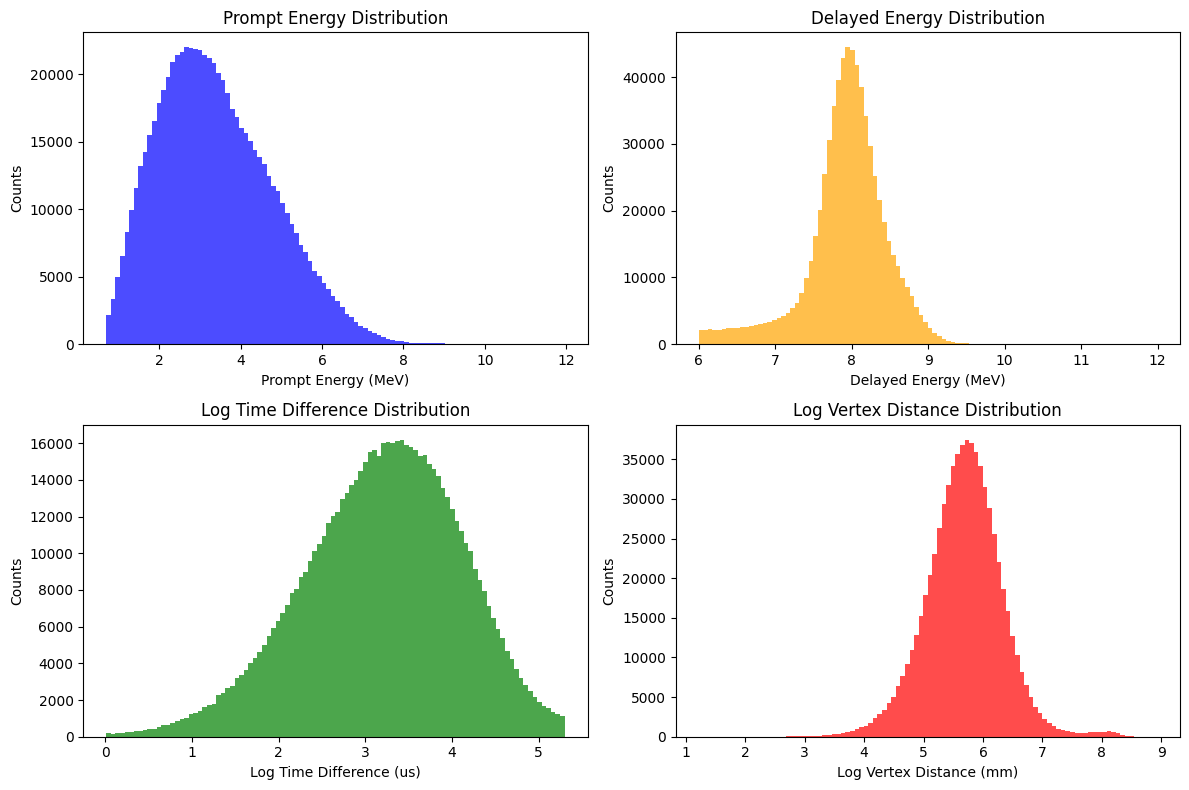

In [62]:
#画出四个直方图
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.hist(ene_p_MeV, bins=100, color='blue', alpha=0.7)
plt.xlabel('Prompt Energy (MeV)')
plt.ylabel('Counts')
plt.title('Prompt Energy Distribution') 
plt.subplot(2, 2, 2)
plt.hist(ene_d_MeV, bins=100, color='orange', alpha=0.7)
plt.xlabel('Delayed Energy (MeV)')
plt.ylabel('Counts')
plt.title('Delayed Energy Distribution')
plt.subplot(2, 2, 3)
plt.hist(log_time_dff_us, bins=100, color='green', alpha=0.7)
plt.xlabel('Log Time Difference (us)')
plt.ylabel('Counts')
plt.title('Log Time Difference Distribution')
plt.subplot(2, 2, 4)
plt.hist(log_vertex_distance_mm, bins=100, color='red', alpha=0.7)
plt.xlabel('Log Vertex Distance (mm)')
plt.ylabel('Counts')
plt.title('Log Vertex Distance Distribution')
plt.tight_layout()
plt.show()

# Encoder学出的主值

In [63]:
pri_value=np.load("../data/latent_repr.npz")
pri_value.keys()

KeysView(NpzFile '../data/latent_repr.npz' with keys: latent, original_features, scaled_features, feature_names, latent_dim)

In [64]:
latent=pri_value['latent']
latent.shape

(695290, 2)

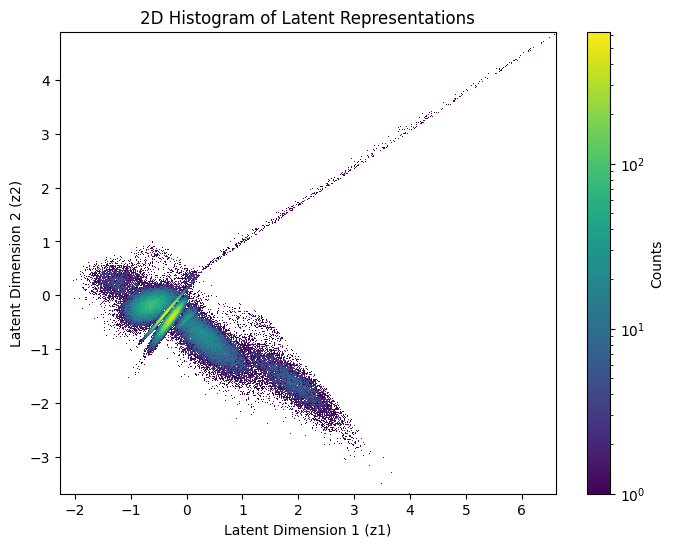

In [77]:
z1=latent[:,0]
z2=latent[:,1]


plt.figure(figsize=(8, 6))
from matplotlib.colors import LogNorm
#用hist2d作图并读取返回
bins=1000
hist, xedges, yedges, im = plt.hist2d(z1, z2, bins=bins, norm=LogNorm())
plt.colorbar(im, label='Counts')
plt.xlabel('Latent Dimension 1 (z1)')
plt.ylabel('Latent Dimension 2 (z2)')
plt.title('2D Histogram of Latent Representations')

plt.show()

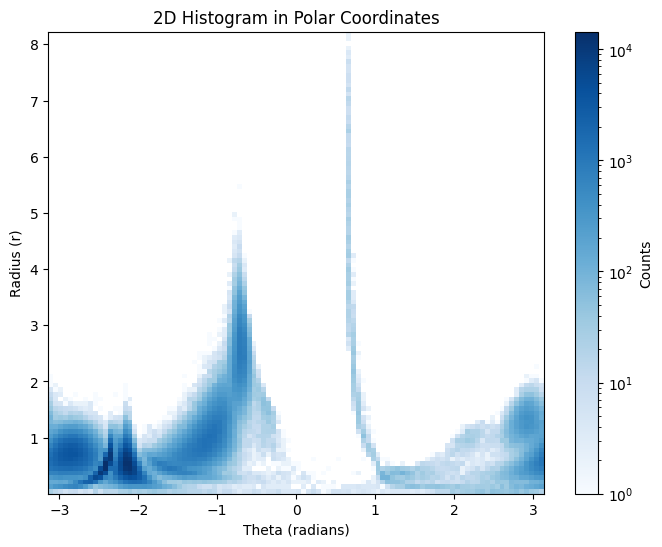

In [66]:
#转到极坐标系并按r-theta画图
r=np.sqrt(z1**2+z2**2)
theta=np.arctan2(z2,z1)

plt.figure(figsize=(8, 6))
plt.hist2d(theta, r, bins=100, cmap='Blues', norm=LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('Theta (radians)')
plt.ylabel('Radius (r)')
plt.title('2D Histogram in Polar Coordinates')
plt.show()

# GMM clustering

In [67]:
#读取data/gmm_clusters.npz
gmm_data=np.load("../data/gmm_clusters.npz")
gmm_data.keys()

FileNotFoundError: [Errno 2] No such file or directory: '../data/gmm_clusters.npz'

In [ ]:
#读取椭圆参数
means=gmm_data['means']
covariances=gmm_data['covariances']
weights=gmm_data['weights']
print("Means:",means)

Means: [[-0.05142932  0.06144566 -0.10921662]
 [-1.1242514   0.6226442   0.26882613]
 [ 3.9462152  -3.897575    5.3677216 ]]


In [ ]:
print("covariances:",covariances)

covariances: [[[ 3.7710935e-01 -1.0352597e-02  2.6502348e-02]
  [-1.0352597e-02  5.0634021e-01 -6.4020924e-02]
  [ 2.6502348e-02 -6.4020924e-02  1.2636238e-01]]

 [[ 7.2553859e+00 -2.9969215e+00 -8.1669974e-01]
  [-2.9969215e+00  1.7161858e+00  3.5547394e-01]
  [-8.1669974e-01  3.5547394e-01  1.8288301e-01]]

 [[ 8.8686428e+00 -8.8292141e+00  1.2135856e+01]
  [-8.8292141e+00  9.7559223e+00 -1.2700251e+01]
  [ 1.2135856e+01 -1.2700251e+01  1.7510153e+01]]]


In [ ]:
print("Weights:",weights)

Weights: [0.9605327  0.02097375 0.01849349]


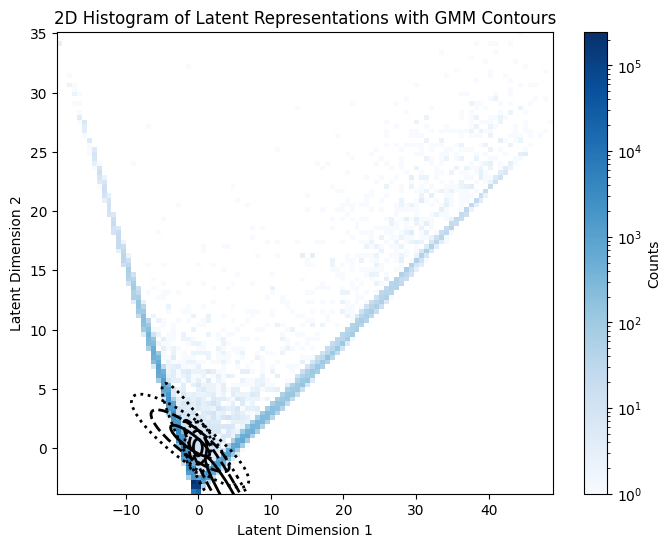

In [ ]:
#画z1,z2的等高线，并标出椭圆
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse 

means_12=means[:, 0:2]

covariances_12=covariances[:, 0:2, 0:2]
def plot_gmm_contours(means, covariances, ax):
    for mean, cov in zip(means, covariances):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        lslist=['-', '--', ':']
        for n_std in range(1, 4):
            width, height = 2 * n_std * np.sqrt(vals)
            ellip = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='black', fc='None', lw=2, ls=lslist[n_std-1],linewidth=0.1)
            ax.add_patch(ellip)
plt.figure(figsize=(8, 6))
from matplotlib.colors import LogNorm
plt.hist2d(z1-0.5, z2-3, bins=100, cmap='Blues',norm=LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Histogram of Latent Representations with GMM Contours')
ax = plt.gca()
plot_gmm_contours(means_12, covariances_12, ax)
plt.show()

# HDBSCAN clustering

In [ ]:
hdb_data=np.load("../data/clusters_hdbscan.npz")
hdb_data.keys()

KeysView(NpzFile '../data/clusters_hdbscan.npz' with keys: latent, latent_scaled, final_labels, stable_mask_lvl1, stable_mask_lvl2...)

In [ ]:
hdb_data['labels'].max()

KeyError: 'labels is not a file in the archive'

In [ ]:
hdb_data["cluster_persistence"]

array([3.19378536e-05, 8.58707706e-03, 1.18711766e-04, 7.99788483e-04,
       8.56227608e-04, 1.32811806e-03, 4.86856612e-01, 5.28717301e-01,
       3.85359124e-04, 6.43885807e-04, 2.19645071e-03, 1.06100561e-03,
       8.41996966e-02, 1.62149901e-03, 6.92377563e-04, 1.51048793e-01])

In [ ]:
hdb_data["cluster_persistence_sub"]

array([0.01966611, 0.01214069, 0.00163359, 0.00191432, 0.00213527,
       0.00827655, 0.00690077, 0.03676849, 0.0911684 , 0.04296523,
       0.06610172, 0.00866924, 0.00401088, 0.03506218, 0.00916472,
       0.01574419, 0.02028592, 0.00350282, 0.00417363, 0.05209623,
       0.09650853, 0.04050096, 0.46277681, 0.05136434, 0.02637078,
       0.10574996])

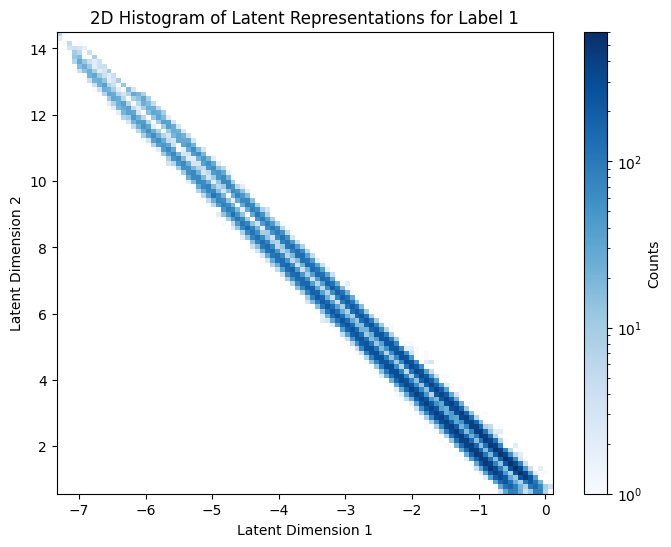

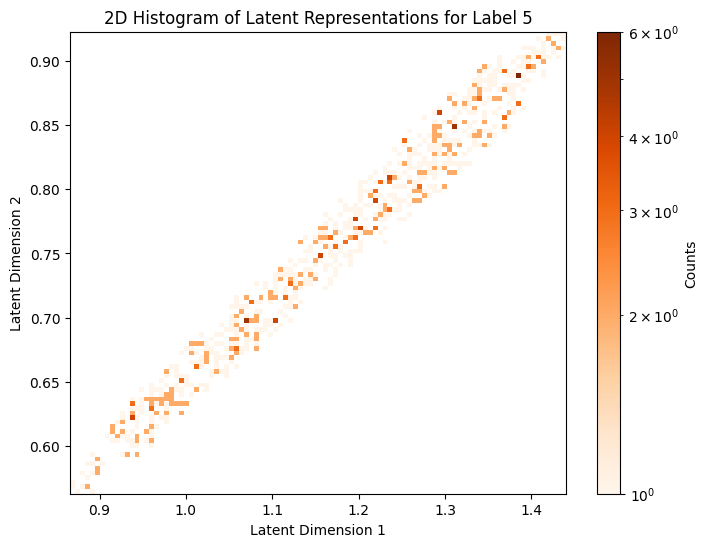

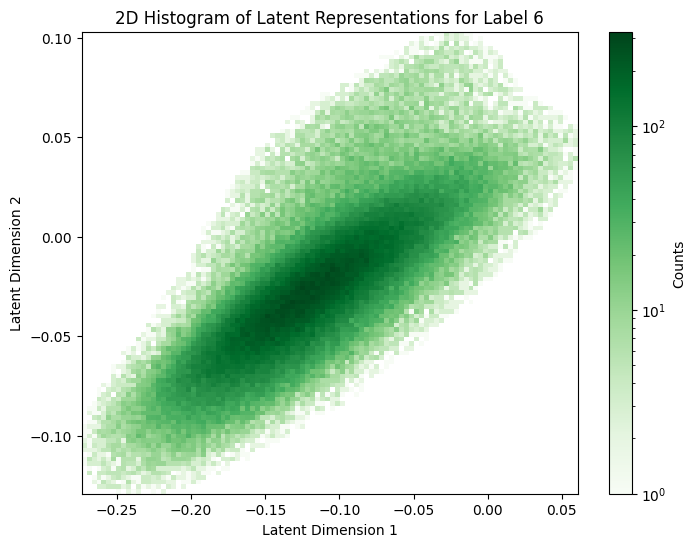

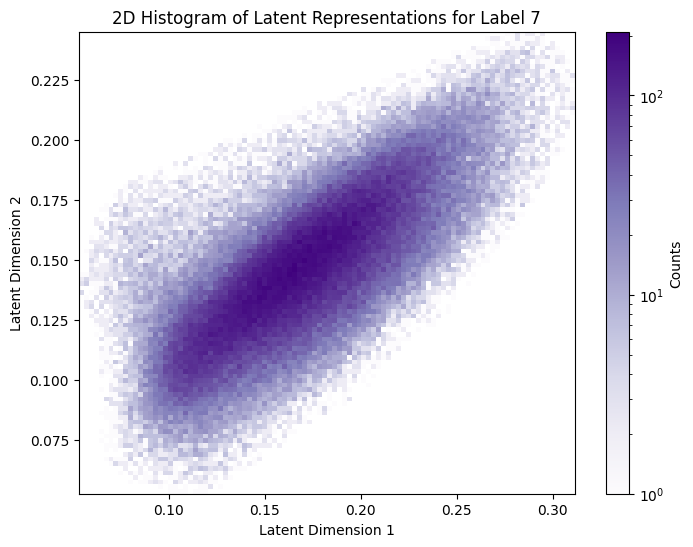

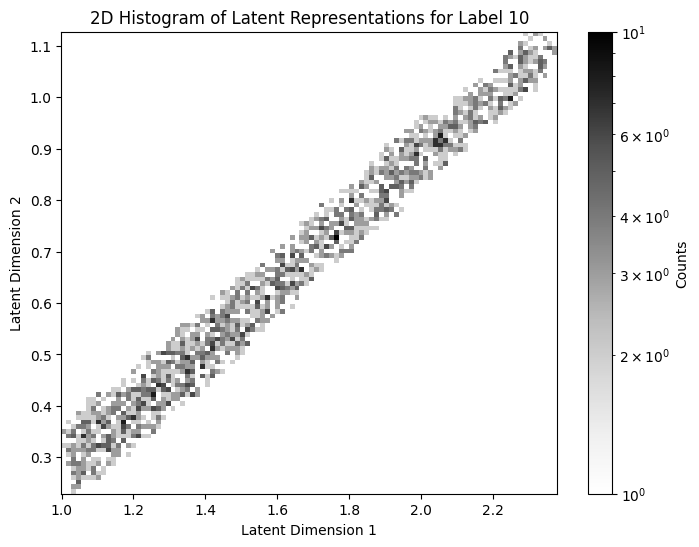

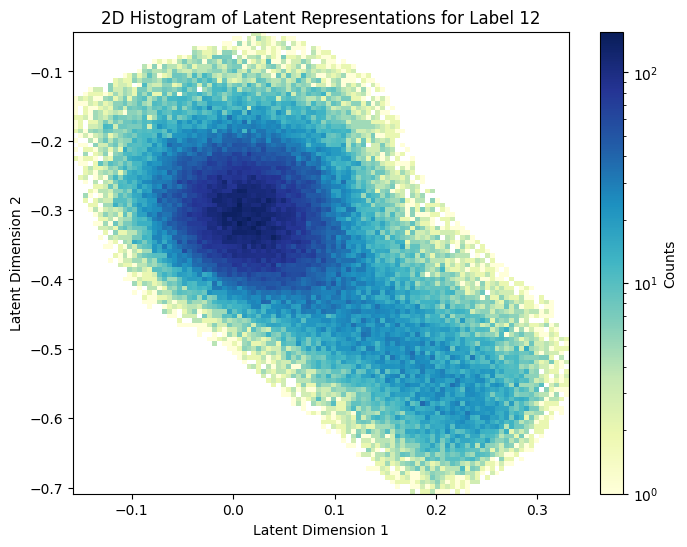

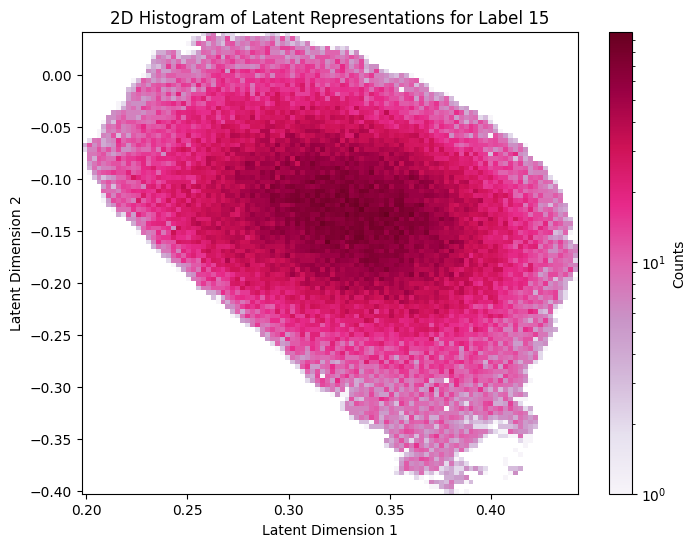

In [ ]:
#对每个可能label画出在z1-z2 hist2d图，要求label不是-1，并且至少要有10000个点
labels=hdb_data['labels']
unique_labels=np.unique(labels)
colors_list=['Blues', 'Oranges', 'Greens', 'Purples', 'Greys', 'YlGnBu', 'PuRd']
color_flag=0
number_of_points=len(labels)
for label in unique_labels: 
    if label == -1:
        continue
    label_mask = (labels == label)
    if np.sum(label_mask) < number_of_points*0.001:
        continue
    plt.figure(figsize=(8, 6))
    plt.hist2d(z1[label_mask], z2[label_mask], bins=100, cmap=colors_list[color_flag], norm=LogNorm())
    color_flag = (color_flag + 1) % len(colors_list)
    plt.colorbar(label='Counts')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(f'2D Histogram of Latent Representations for Label {label}')
    plt.show()

Plotting label 1 with 86178 points.
Plotting label 5 with 911 points.
Plotting label 6 with 199817 points.
Plotting label 7 with 168406 points.
Plotting label 10 with 3704 points.
Plotting label 12 with 118852 points.
Plotting label 15 with 145978 points.


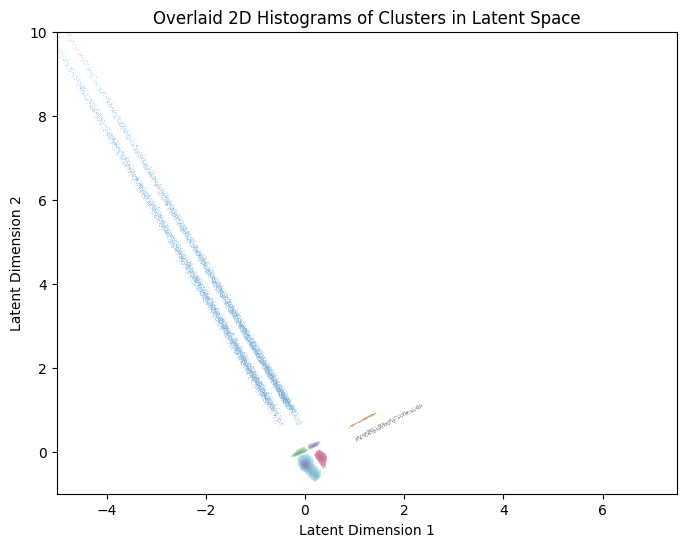

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

labels = hdb_data['labels']
unique_labels = np.unique(labels)

colors_list = ['Blues', 'Oranges', 'Greens', 'Purples', 'Greys', 'YlGnBu', 'PuRd']

fig, ax = plt.subplots(figsize=(8, 6))
bins=(np.linspace(-5, 7.5, 1000), np.linspace(-1, 10, 1000))
color_flag = 0
for label in unique_labels:
    if label == -1:
        continue

    label_mask = (labels == label)
    if np.sum(label_mask) < number_of_points*0.001:
        continue
    print(f"Plotting label {label} with {np.sum(label_mask)} points.")
    ax.hist2d(
        z1[label_mask],
        z2[label_mask],
        bins=bins,
        cmap=colors_list[color_flag],
        norm=LogNorm(),
        alpha=0.5    # 关键：半透明叠加
    )

    color_flag = (color_flag + 1) % len(colors_list)

ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Overlaid 2D Histograms of Clusters in Latent Space')

plt.show()


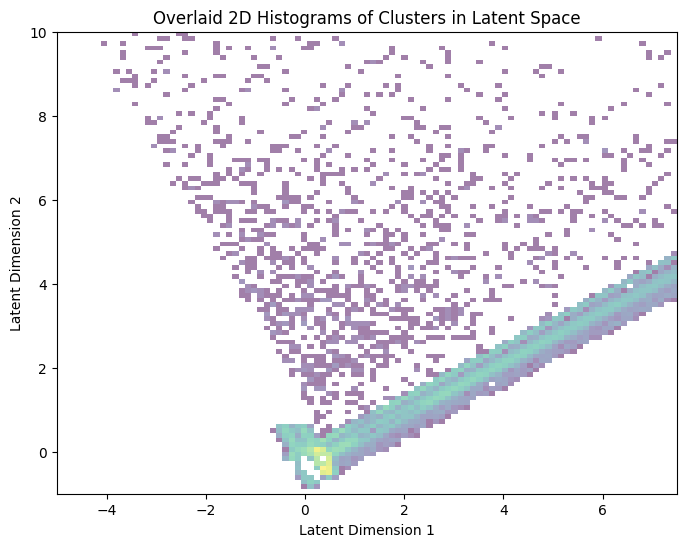

In [ ]:
#把实例数小于10000的cluster和噪声全画在一张图上（不分团，直接一起计数）
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
labels = hdb_data['labels']
unique_labels = np.unique(labels)
bins=(np.linspace(-5, 7.5, 100), np.linspace(-1, 10, 100))
fig, ax = plt.subplots(figsize=(8, 6))

non_structured_mask = np.ones_like(labels, dtype=bool)

for label in unique_labels:
    label_mask = (labels == label)
    if np.sum(label_mask) > number_of_points*0.001 and label != -1:
        non_structured_mask[label_mask] = False
    
ax.hist2d(
    z1[non_structured_mask],
    z2[non_structured_mask],
    bins=bins,
    norm=LogNorm(),
    alpha=0.5
)

ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Overlaid 2D Histograms of Clusters in Latent Space')

plt.show()

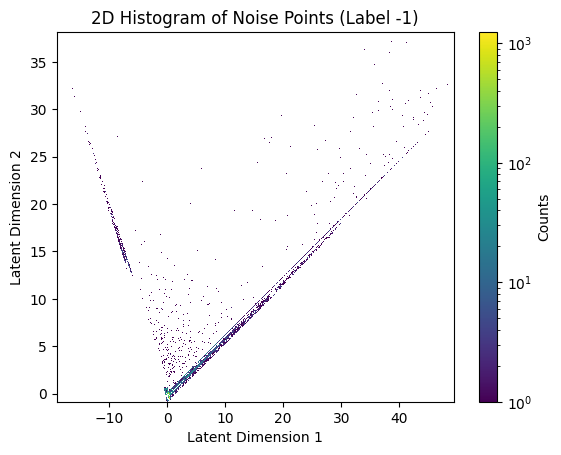

In [ ]:
#画label=-1的事件分布
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
labels = hdb_data['labels']
label_mask = (labels == -1)
plt.hist2d(z1[label_mask], z2[label_mask], bins=1000,norm=LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Histogram of Noise Points (Label -1)')
plt.show()

In [ ]:
hdb_data['labels_sub'].max()

np.int64(25)

Plotting sub label 0 with 2188 points.
Plotting sub label 1 with 3483 points.
Plotting sub label 9 with 2542 points.
Plotting sub label 16 with 6547 points.
Plotting sub label 22 with 24963 points.


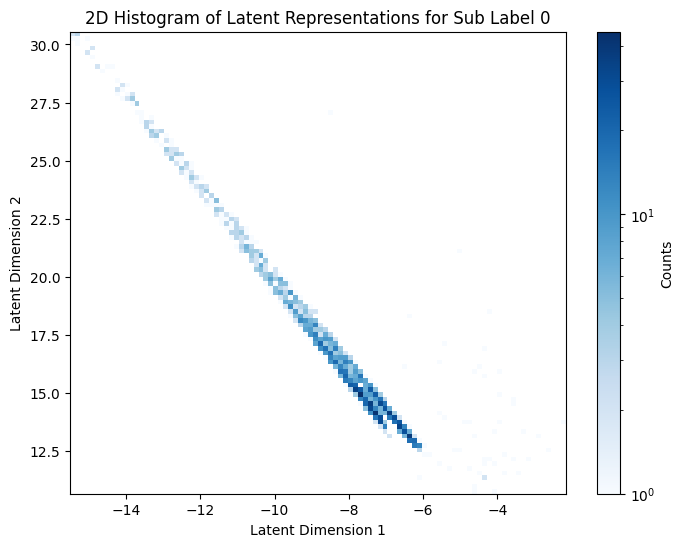

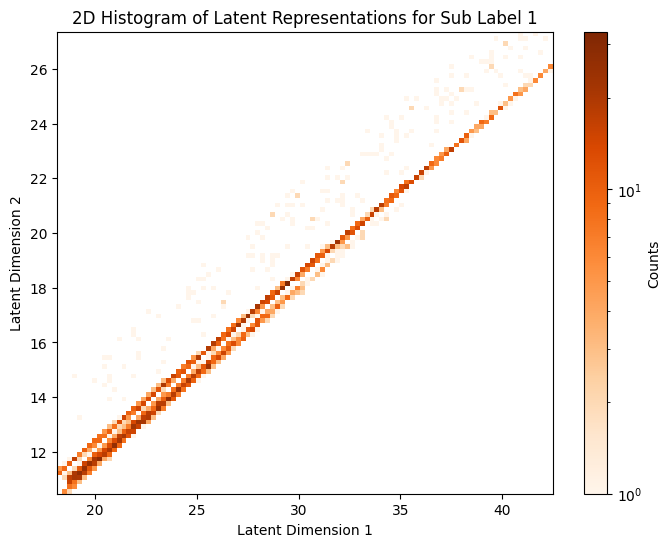

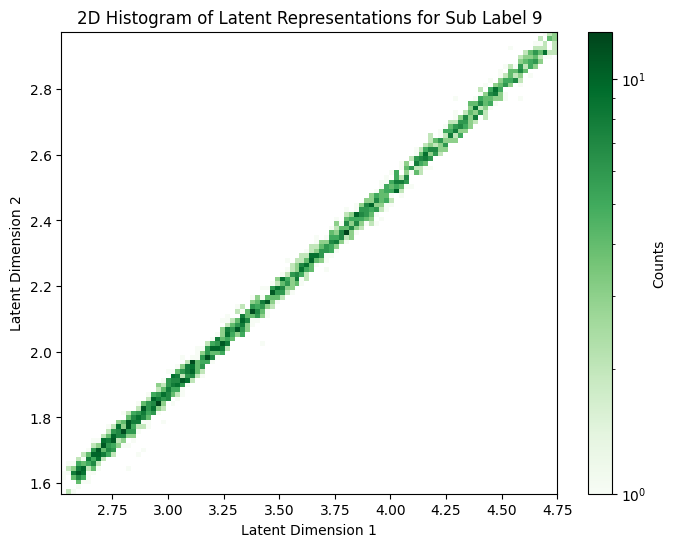

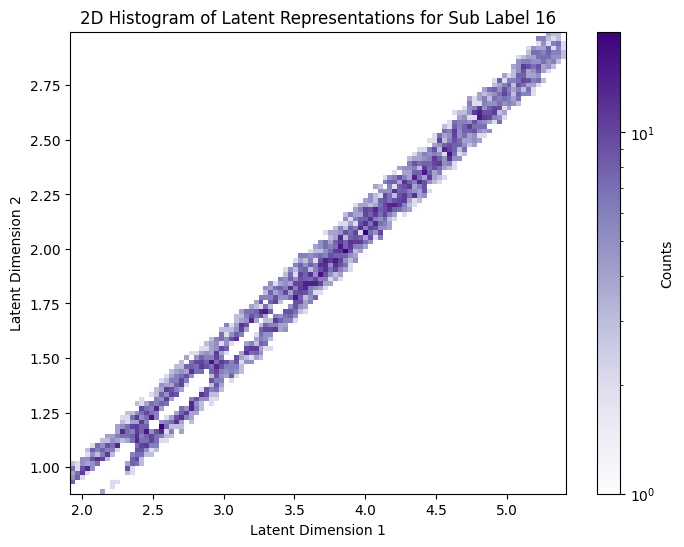

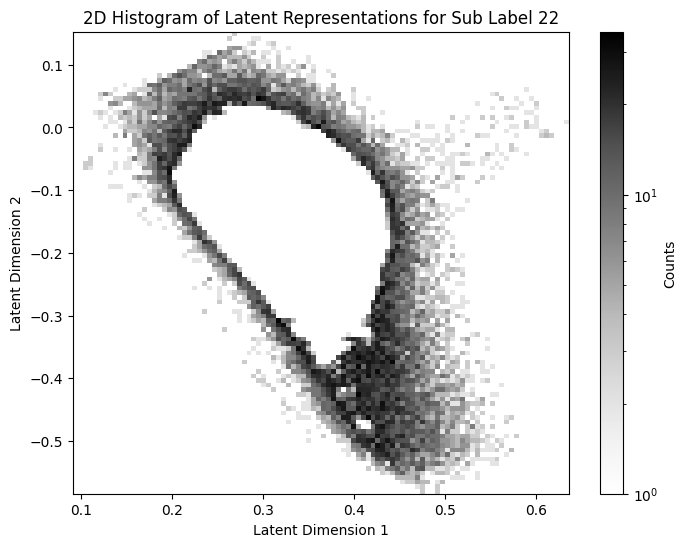

In [ ]:
#labels_sub是按噪声再聚类得到的
#画出sub的聚类结果
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
labels_sub = hdb_data['labels_sub']
unique_sub_labels = np.unique(labels_sub)
colors_list=['Blues', 'Oranges', 'Greens', 'Purples', 'Greys', 'YlGnBu', 'PuRd']
color_flag=0
number_of_points=len(labels_sub)
for label in unique_sub_labels: 
    if label == -1:
        continue
    label_mask = (labels_sub == label)
    if np.sum(label_mask) < number_of_points*0.03:
        continue
    print(f"Plotting sub label {label} with {np.sum(label_mask)} points.")
    plt.figure(figsize=(8, 6))
    plt.hist2d(z1[labels== -1][label_mask], z2[labels==-1][label_mask], bins=100, cmap=colors_list[color_flag], norm=LogNorm())
    color_flag = (color_flag + 1) % len(colors_list)
    plt.colorbar(label='Counts')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(f'2D Histogram of Latent Representations for Sub Label {label}')
plt.show()

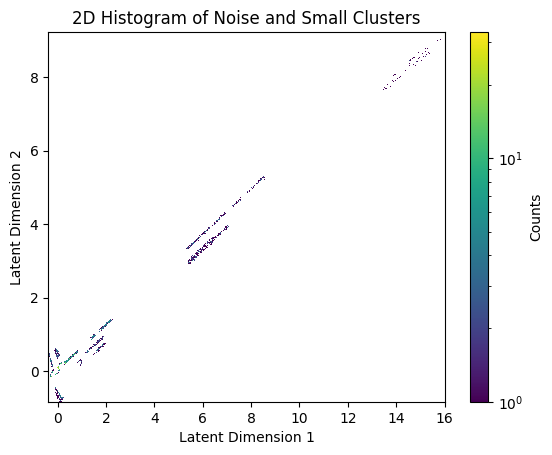

In [ ]:
#画出小cluster和噪声的总分布
#要求是噪声或者小于 number_of_points*0.03个点的cluster
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
non_structured_mask = np.ones_like(labels_sub, dtype=bool)
for label in unique_sub_labels: 
    label_mask = (labels_sub == label)
    if np.sum(label_mask) > number_of_points*0.03:
        non_structured_mask[label_mask] = False
plt.hist2d(z1[labels== -1][non_structured_mask], z2[labels==-1][non_structured_mask], bins=1000,norm=LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Histogram of Noise and Small Clusters')
plt.show()

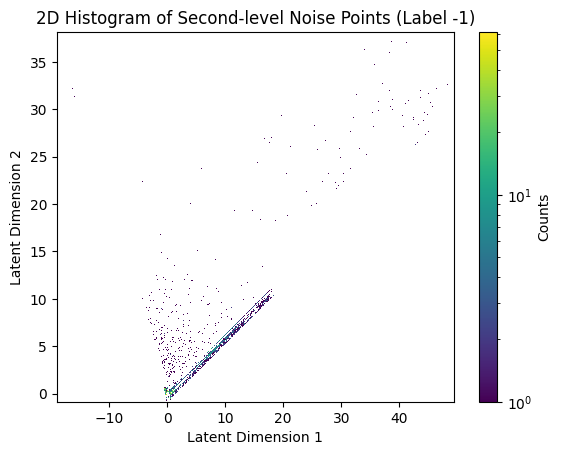

In [ ]:
#只画二阶噪声
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
labels_sub = hdb_data['labels_sub']
label_mask = (labels_sub == -1)
plt.hist2d(z1[labels== -1][label_mask], z2[labels==-1][label_mask], bins=1000,norm=LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Histogram of Second-level Noise Points (Label -1)')
plt.show()

# 综合cluster

In [68]:
import numpy as np
import matplotlib.pyplot as plt
cluster_total=np.load("../data/clusters.npz")
cluster_total.keys()

KeysView(NpzFile '../data/clusters.npz' with keys: labels, latent, latent_scaled, params)

(695290,)

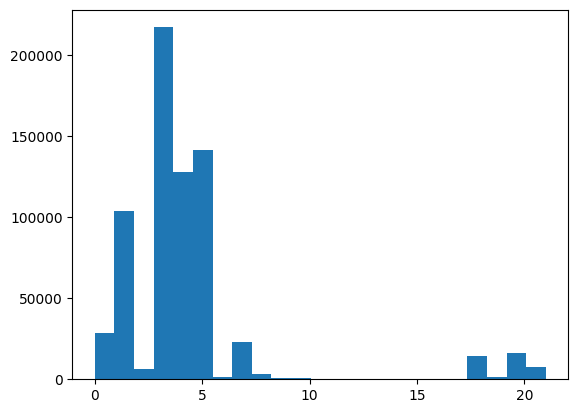

In [ ]:
labels=cluster_total['labels']
plt.hist(labels, bins=labels.max()+2)
labels.shape


Plotting label 21 with 7318 points.


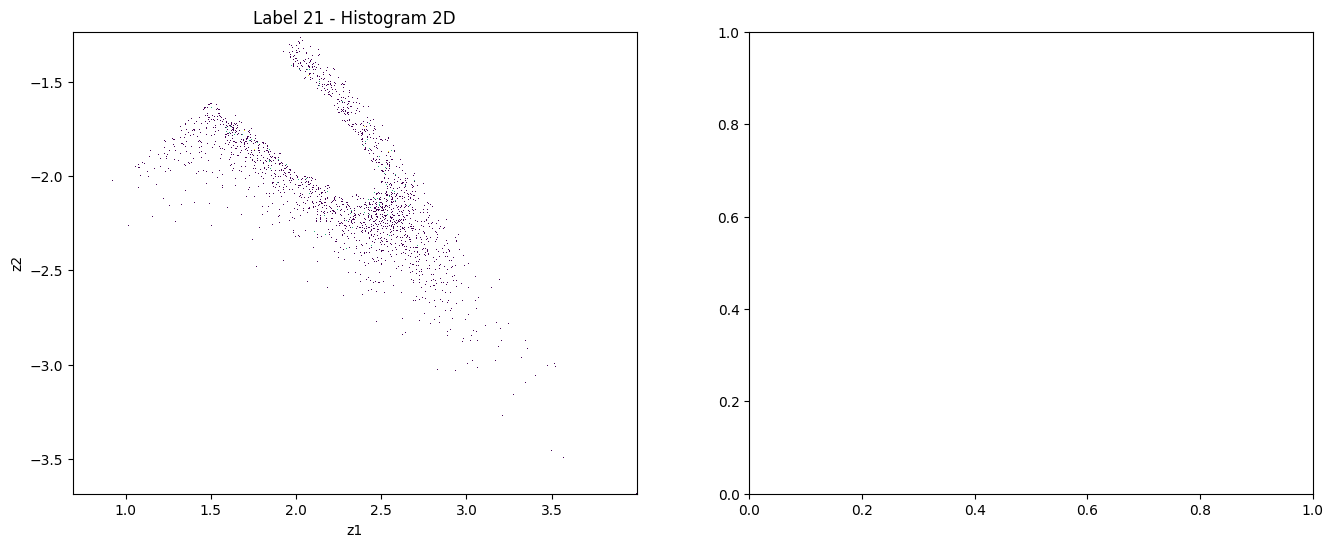

Plotting label 20 with 16479 points.


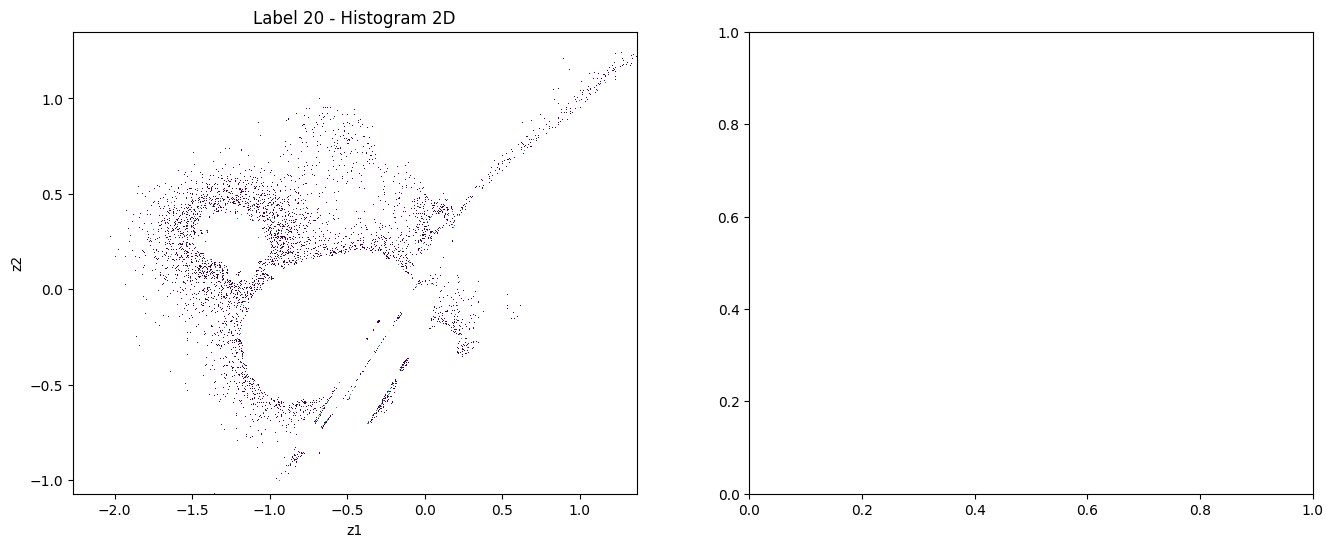

Plotting label 19 with 1660 points.


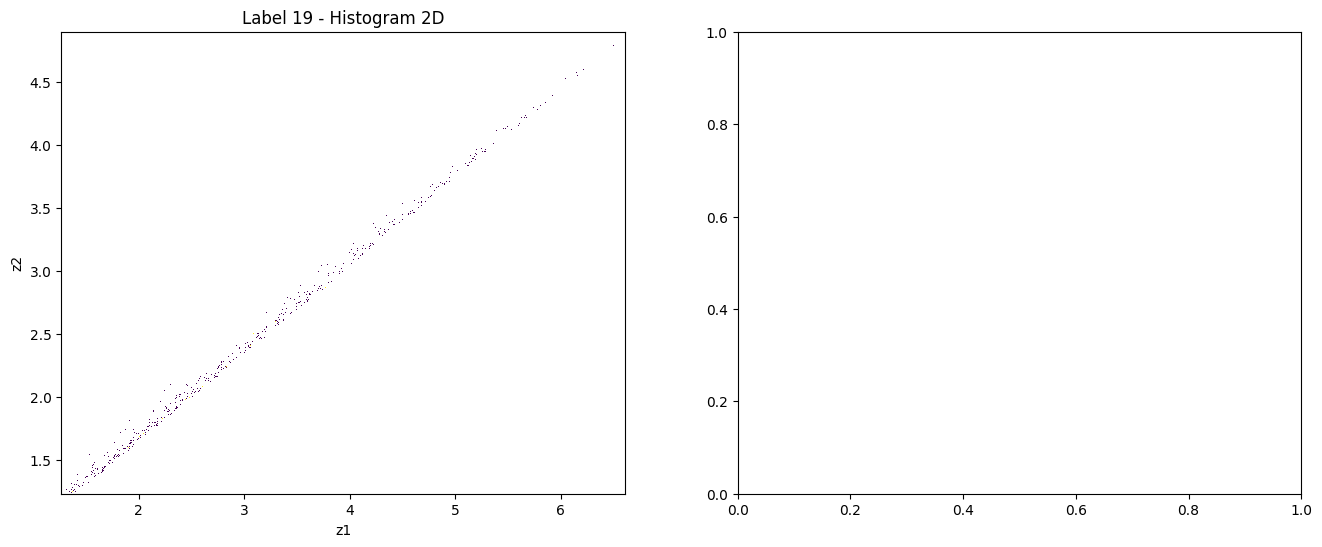

Plotting label 18 with 14387 points.


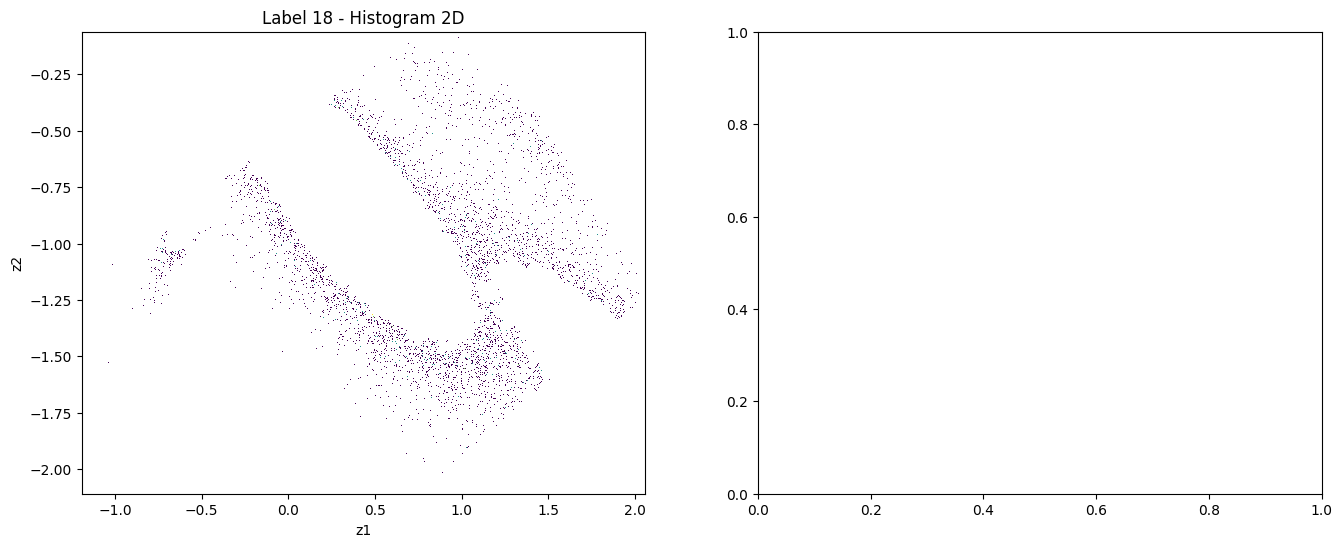

Plotting label 17 with 101 points.


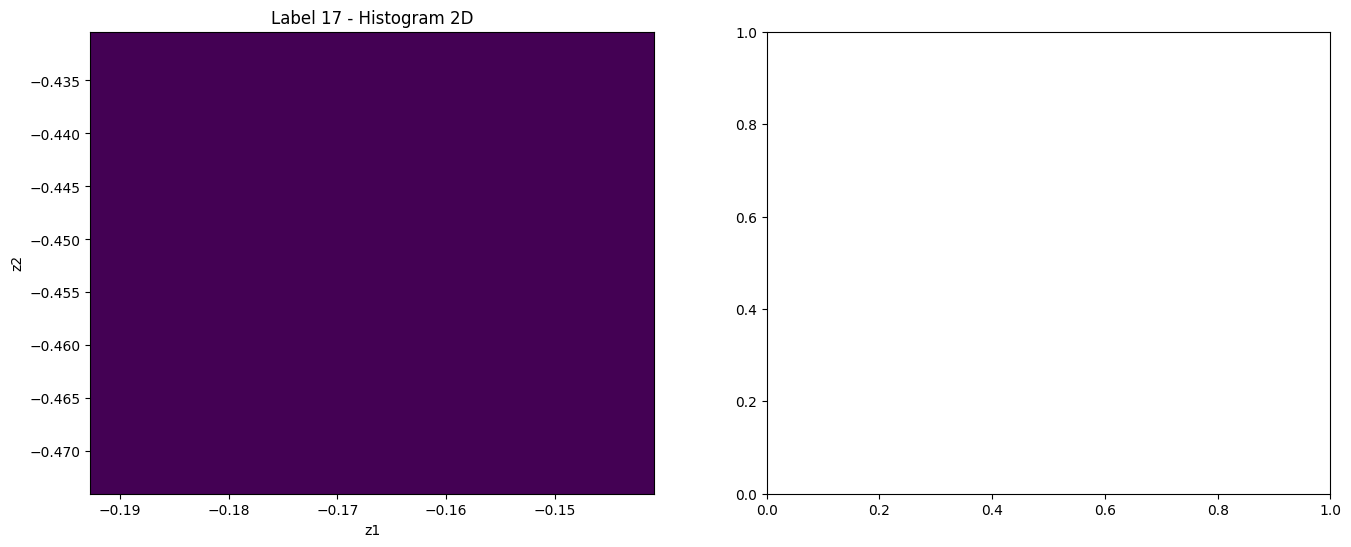

Plotting label 16 with 115 points.


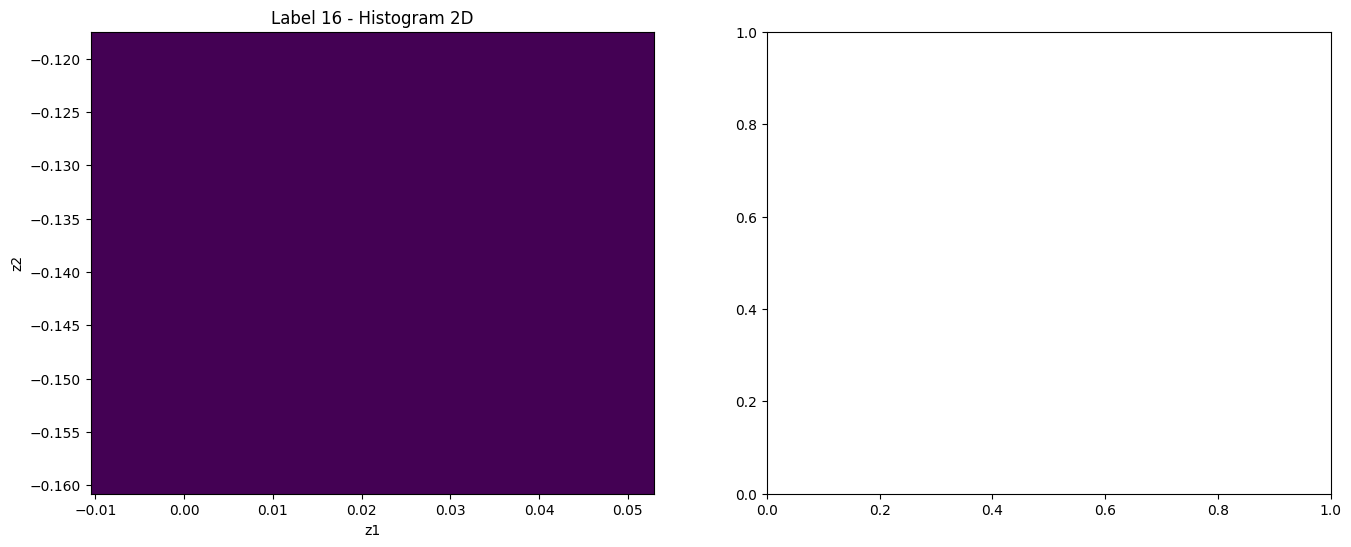

Plotting label 15 with 181 points.


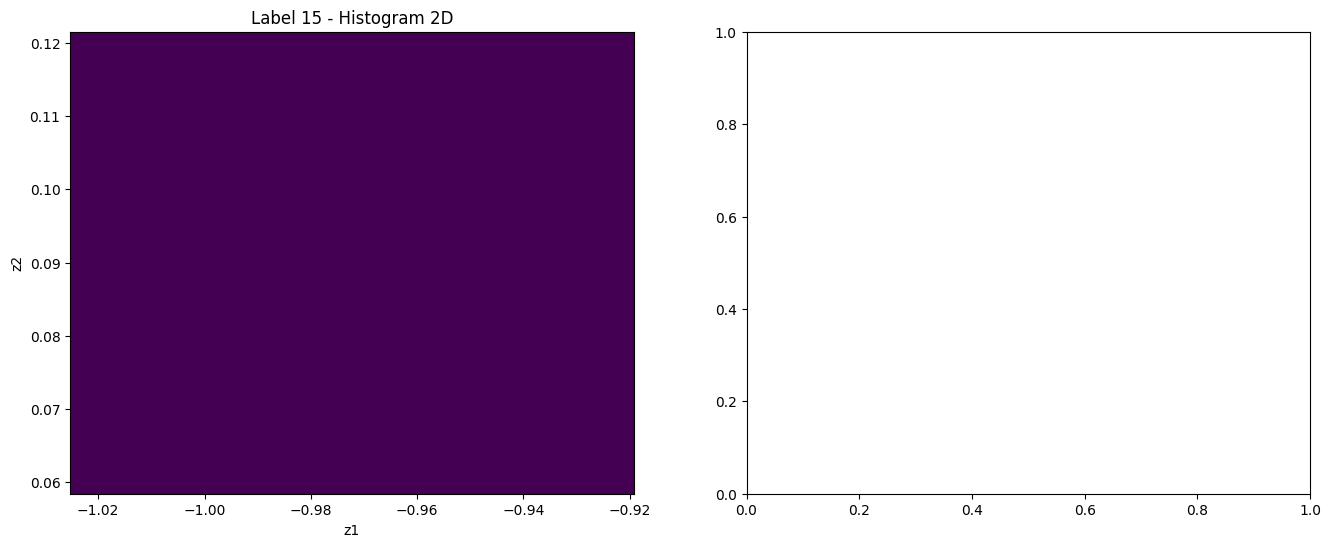

Plotting label 14 with 109 points.


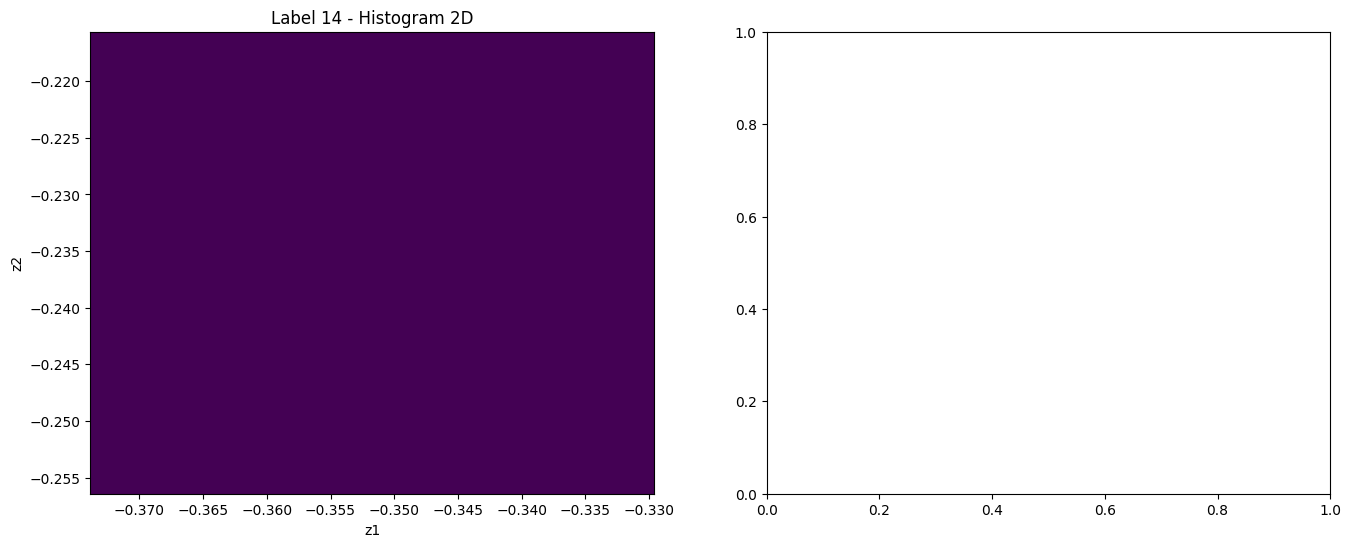

Plotting label 13 with 252 points.


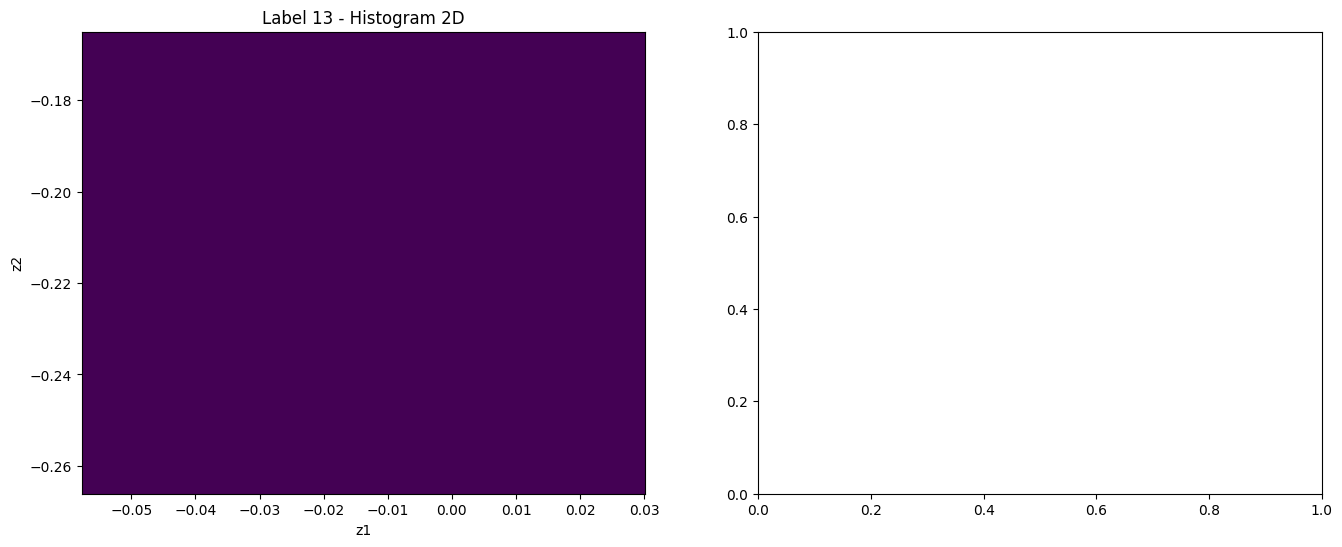

Plotting label 12 with 216 points.


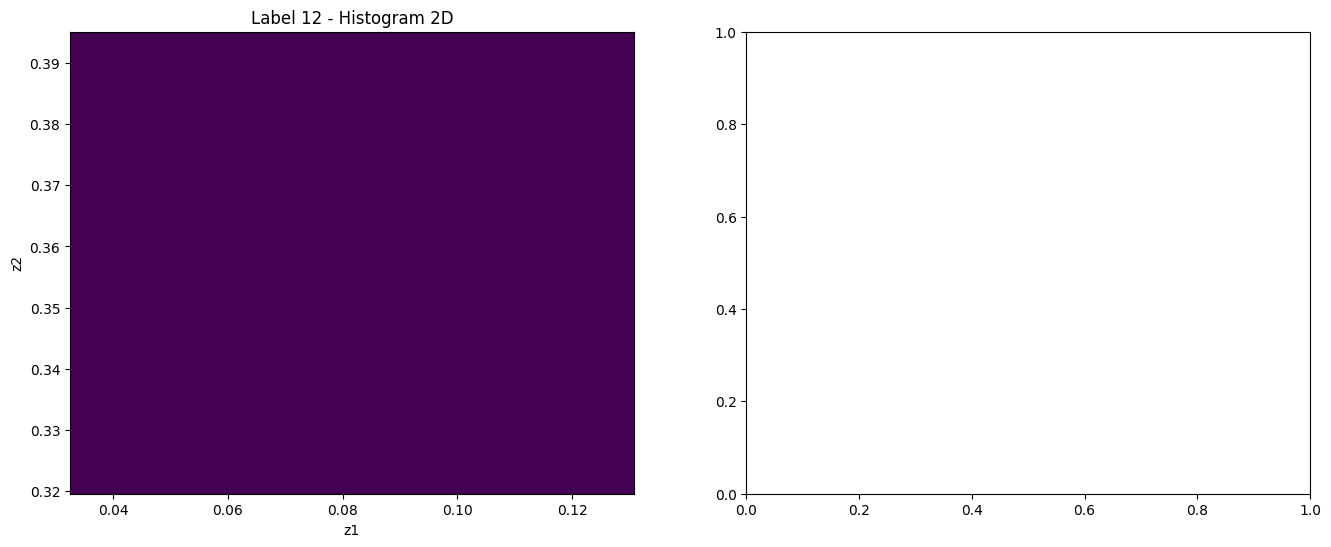

Plotting label 11 with 255 points.


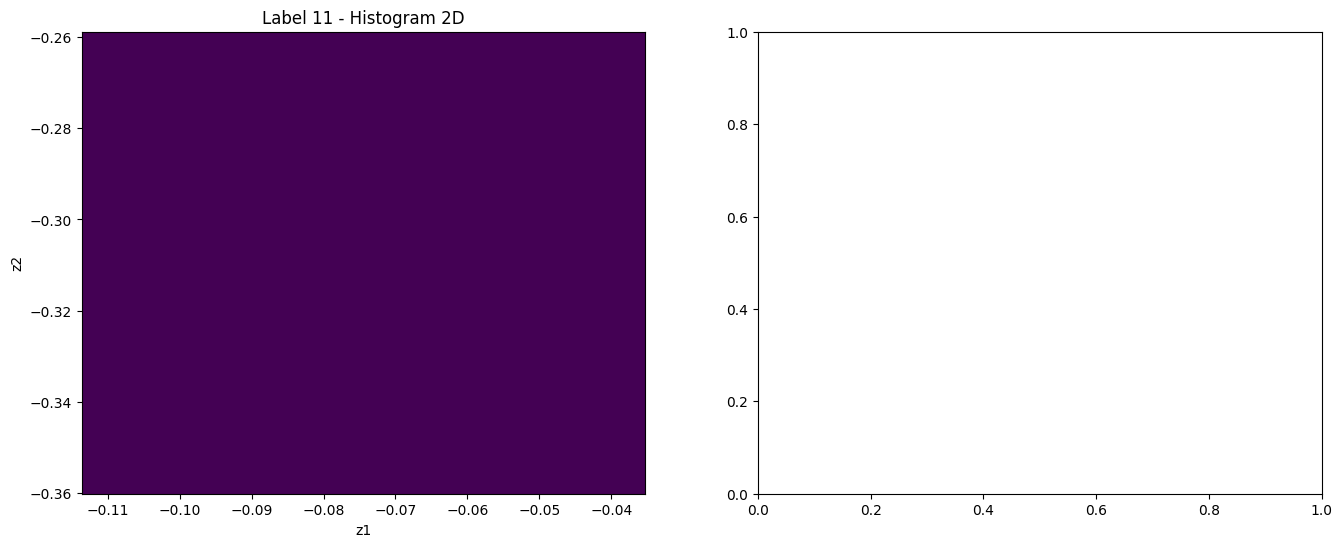

Plotting label 10 with 1094 points.


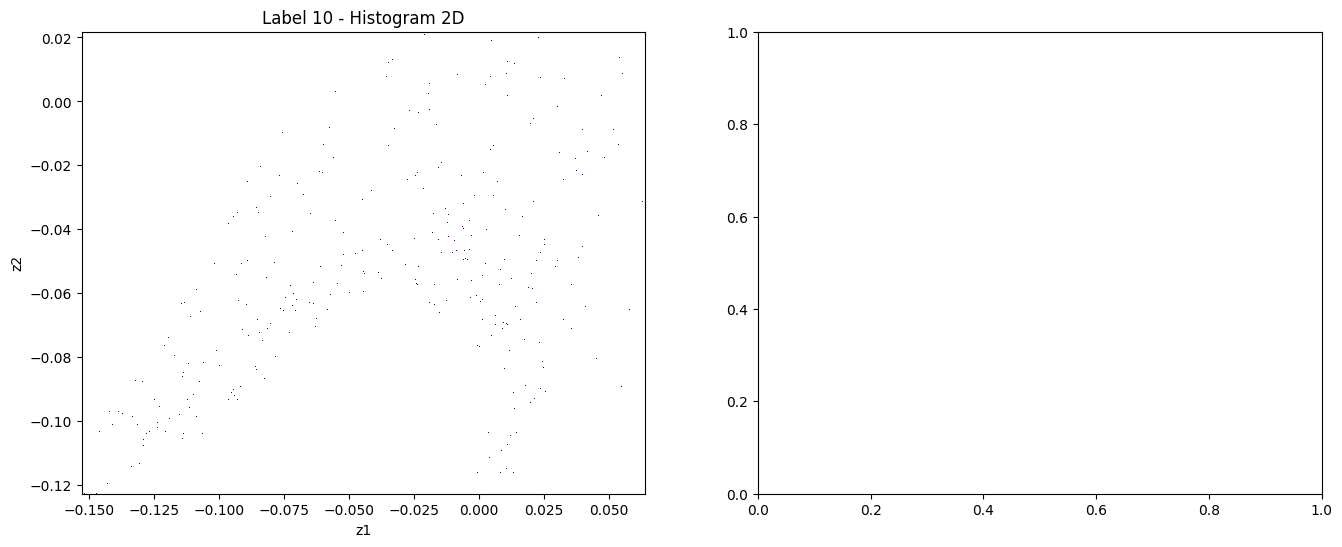

Plotting label 9 with 695 points.


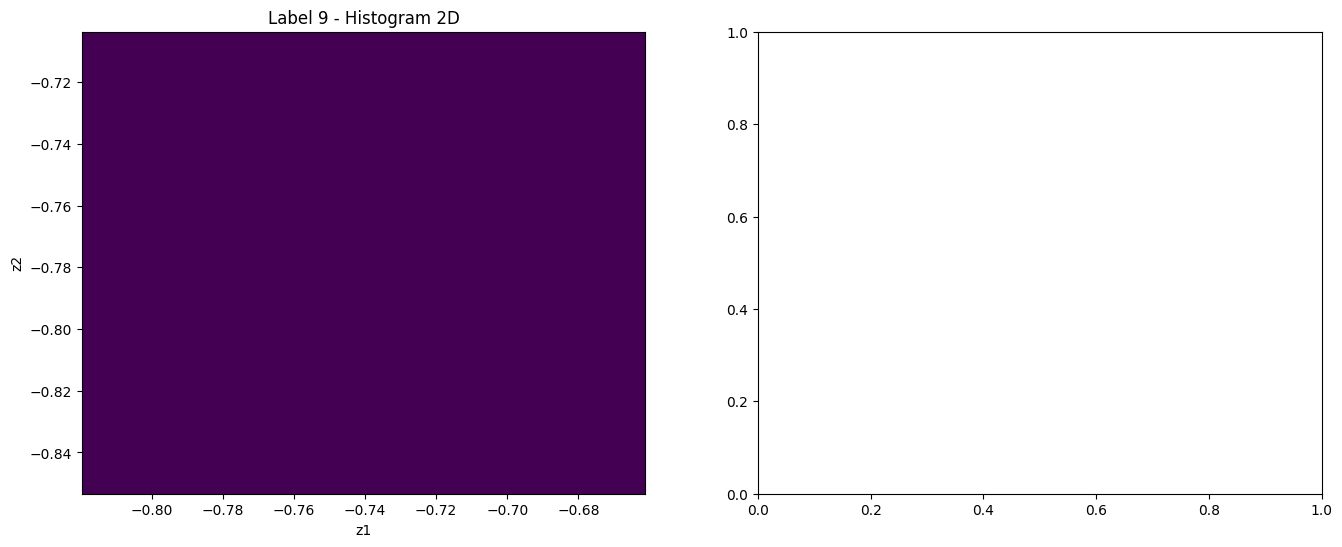

Plotting label 8 with 2981 points.


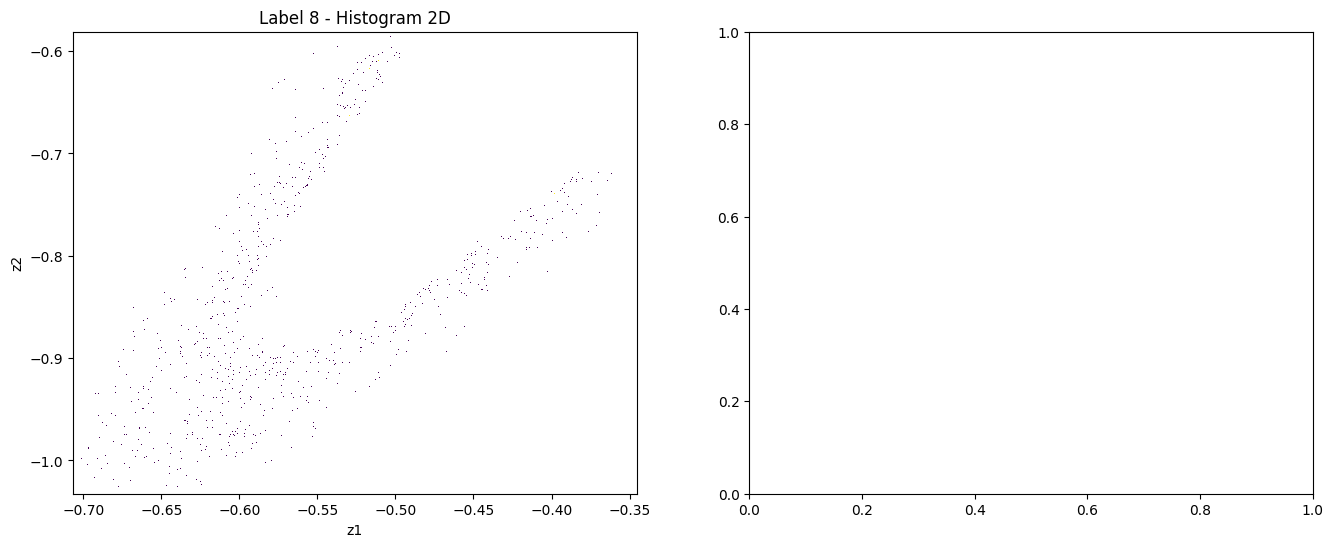

Plotting label 7 with 22896 points.


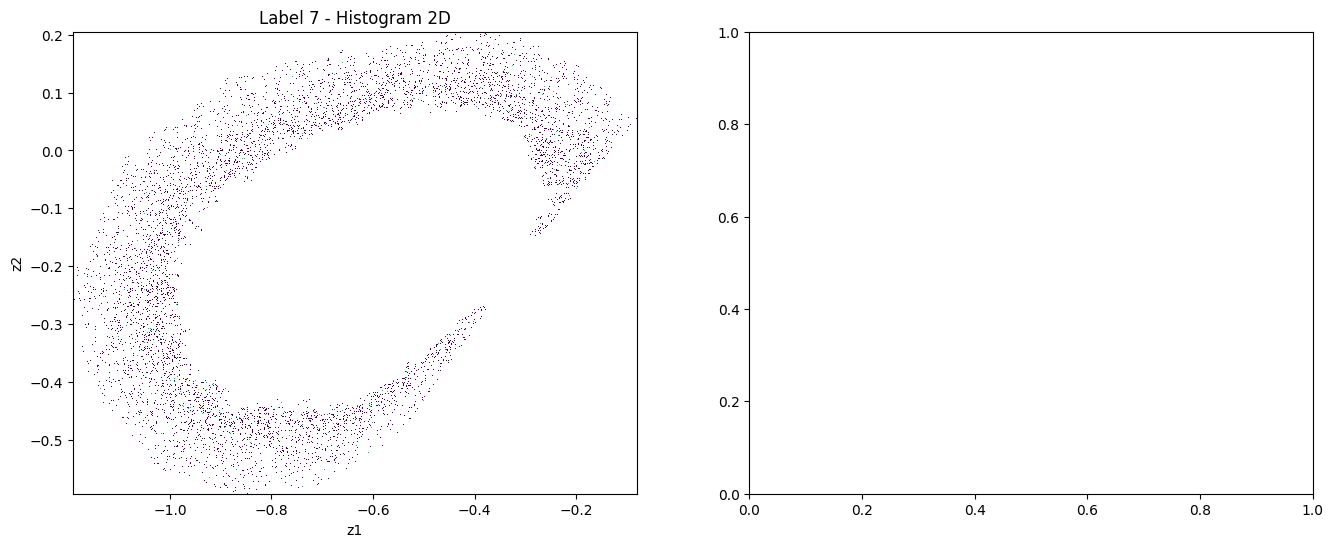

Plotting label 6 with 1267 points.


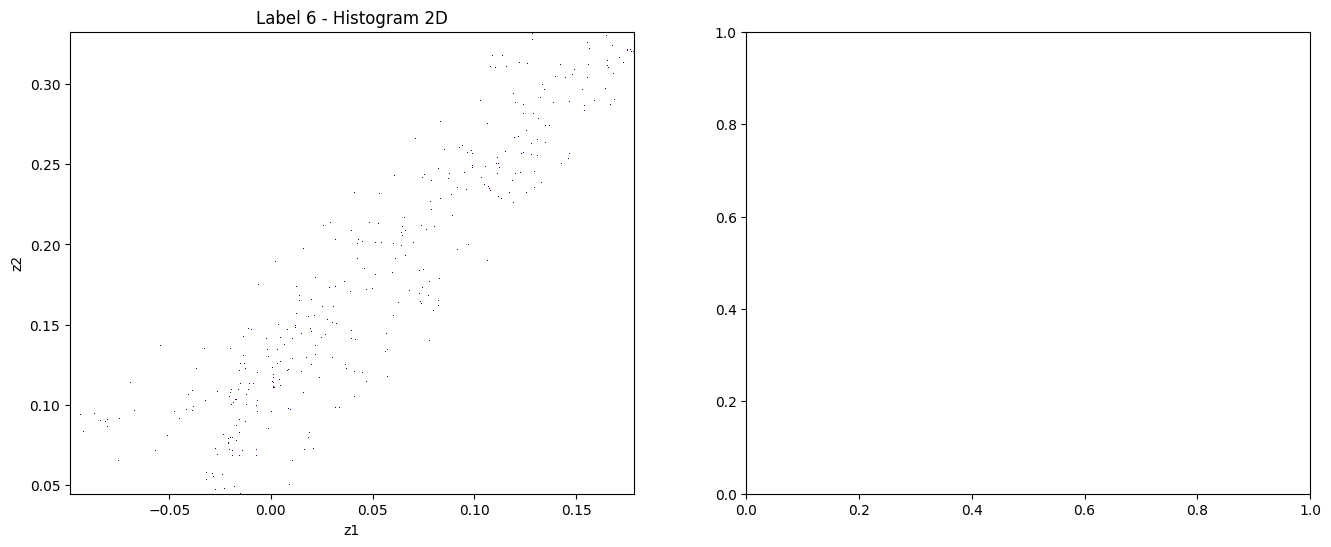

Plotting label 5 with 141487 points.


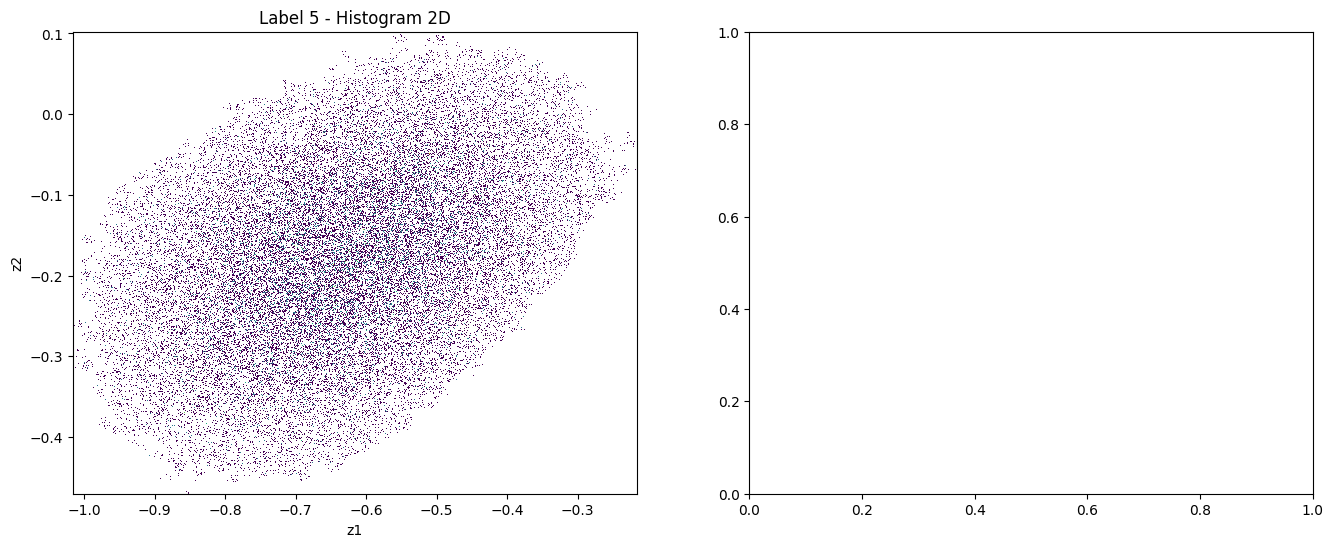

Plotting label 4 with 127833 points.


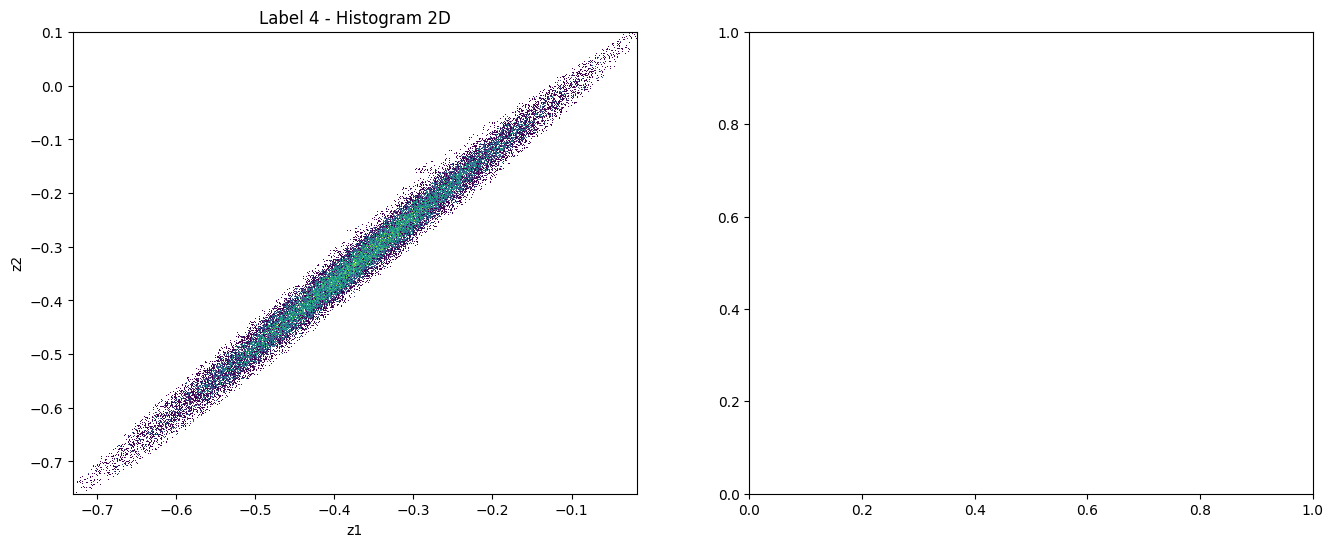

Plotting label 3 with 217106 points.


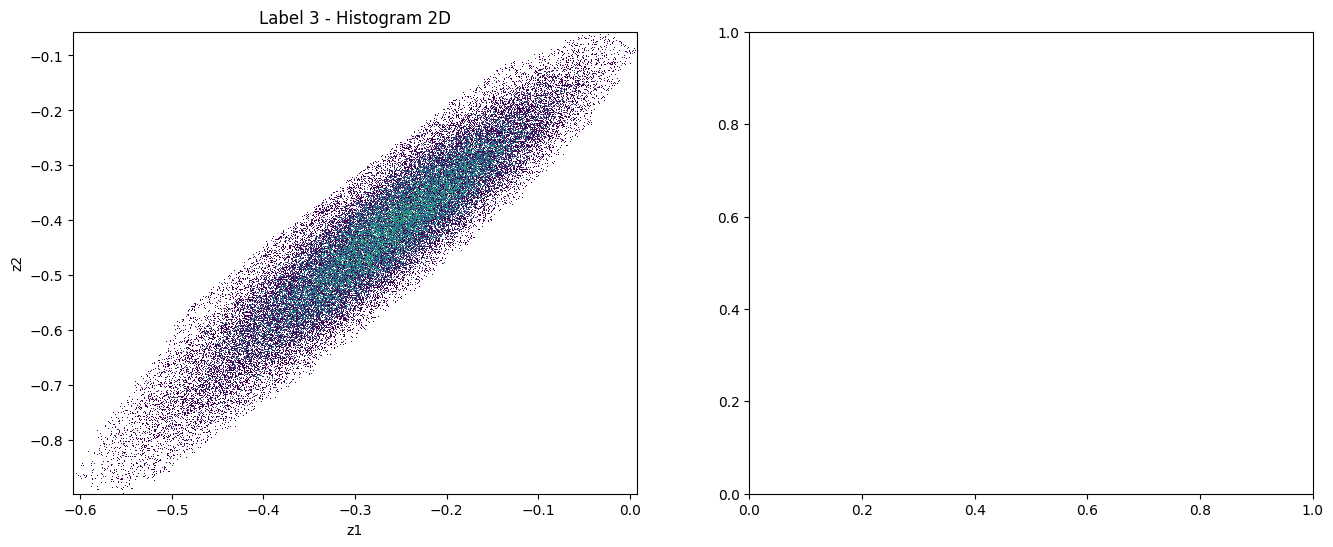

Plotting label 2 with 6193 points.


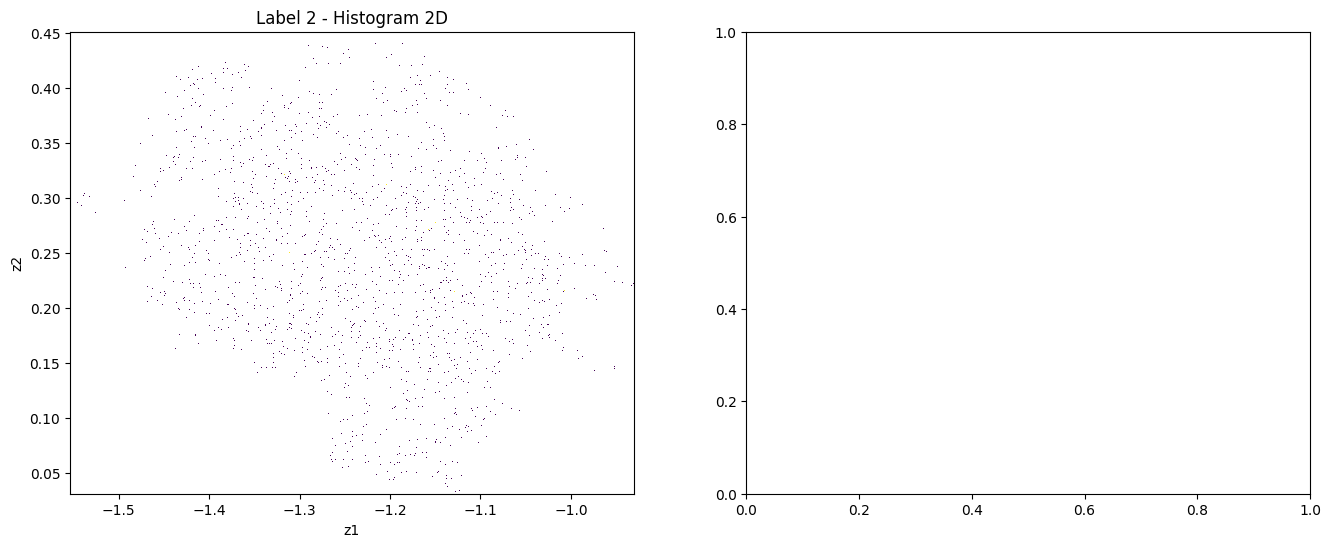

Plotting label 1 with 104051 points.


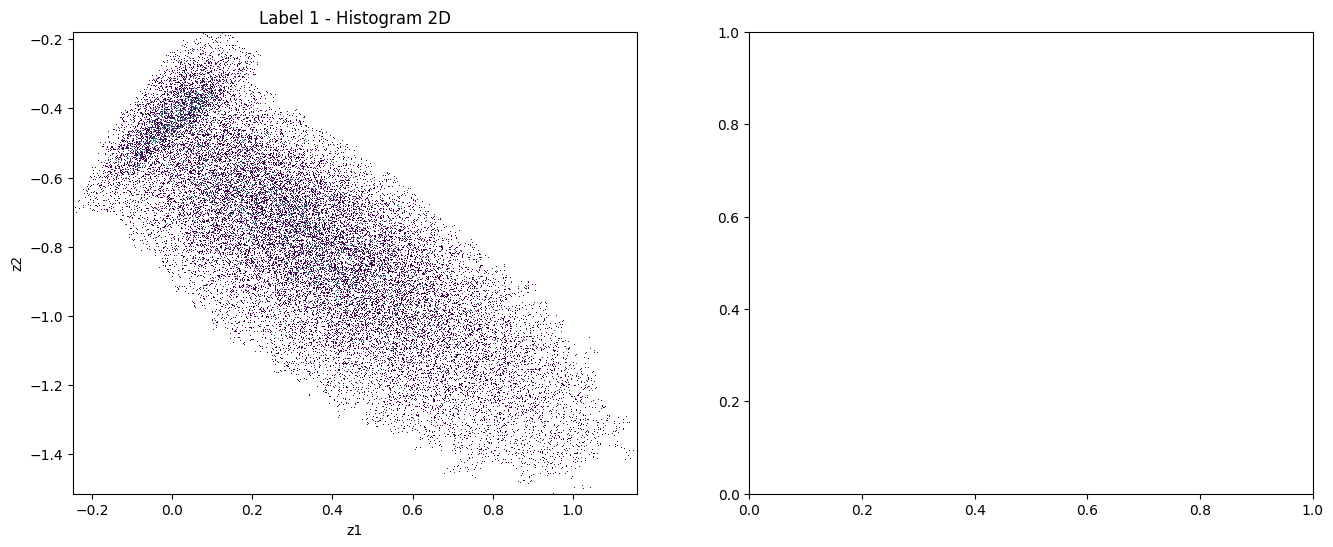

Plotting label 0 with 28614 points.


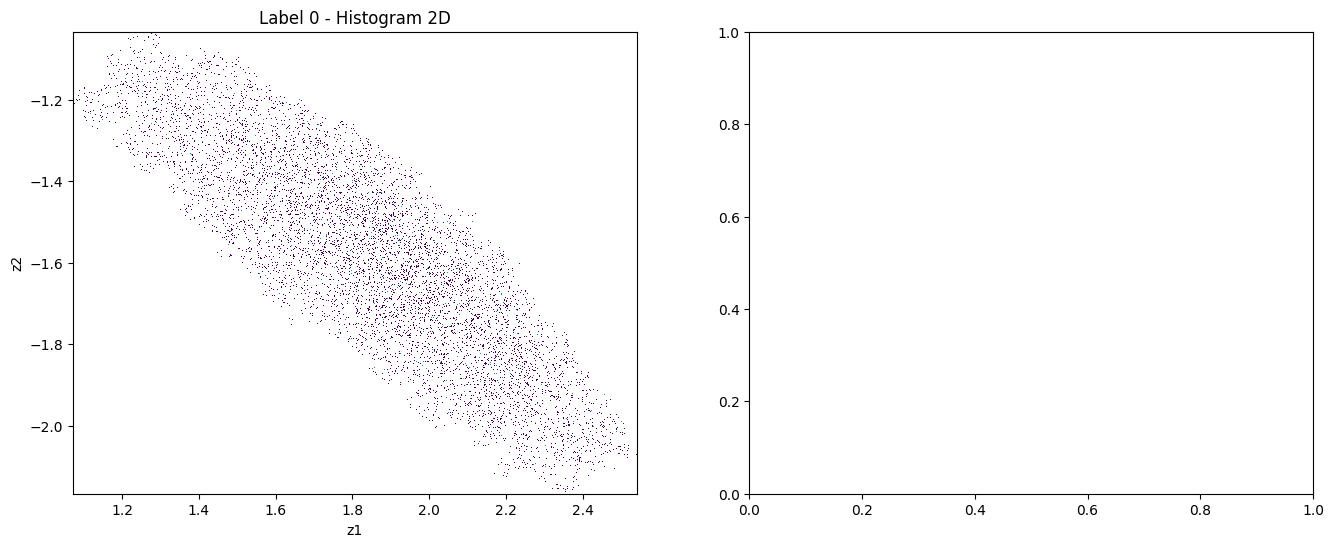

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 
cluster_total=np.load("../data/clusters.npz")
labels=cluster_total['labels']
unique_labels, counts = np.unique(labels, return_counts=True)


colors_list = ['Blues', 'Oranges', 'Greens', 'Purples', 'Greys', 'YlGnBu', 'PuRd']

bins_global=(np.linspace(-5, 7.5, 1000), np.linspace(-1, 10, 1000))
color_flag = 0
for label in np.flip(unique_labels):
    label_mask = (labels == label)
    print(f"Plotting label {label} with {np.sum(label_mask)} points.")
    
    #画两张子图
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    #第一张是直接把label_mask的点画出来
    #bins设置为1000，读取输出的xedges和yedges
    hist, xedges, yedges, im = axs[0].hist2d(
        z1[label_mask],
        z2[label_mask],
        bins=500,
        norm=LogNorm()
    )
    axs[0].set_title(f"Label {label} - Histogram 2D")
    axs[0].set_xlabel("z1")
    axs[0].set_ylabel("z2")
    
    #第二张是用全局的bins_global画图
    axs[1].hist2d(
        z1[label_mask],
        z2[label_mask],
        bins=bins_global,
        norm=LogNorm()
    )
    axs[1].set_title(f"Label {label} - Histogram 2D (Global Bins)")
    axs[1].set_xlabel("z1")
    axs[1].set_ylabel("z2")
    #然后用
    
    plt.show()

    

Plotting label 21 with 7318 points.


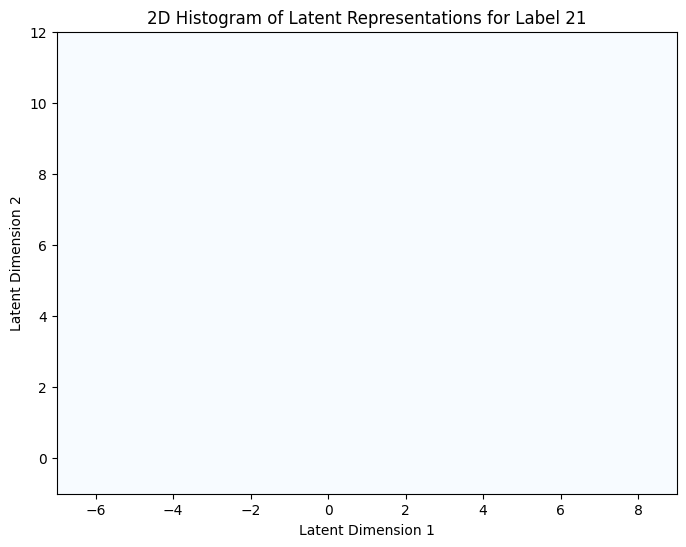

Plotting label 20 with 16479 points.


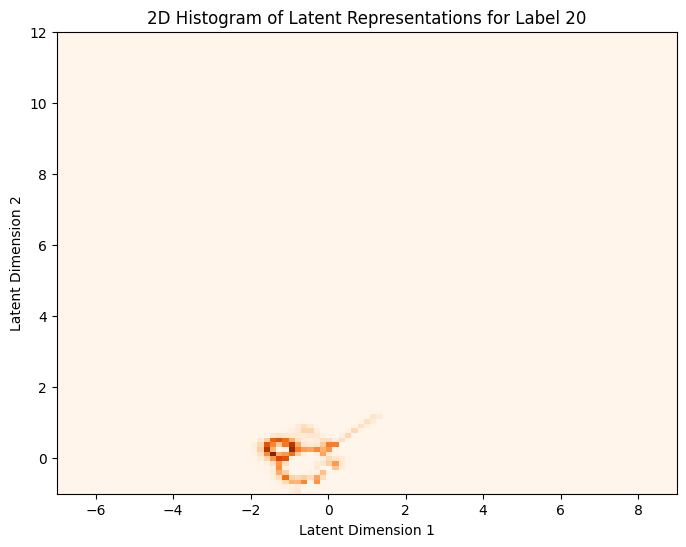

Plotting label 19 with 1660 points.


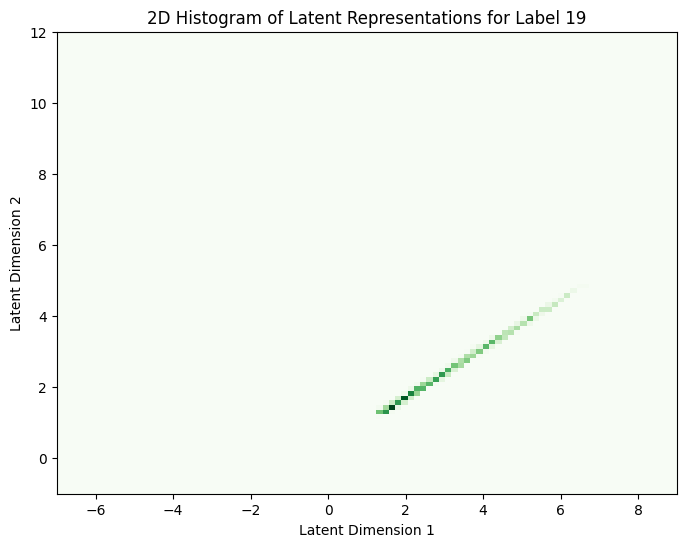

Plotting label 18 with 14387 points.


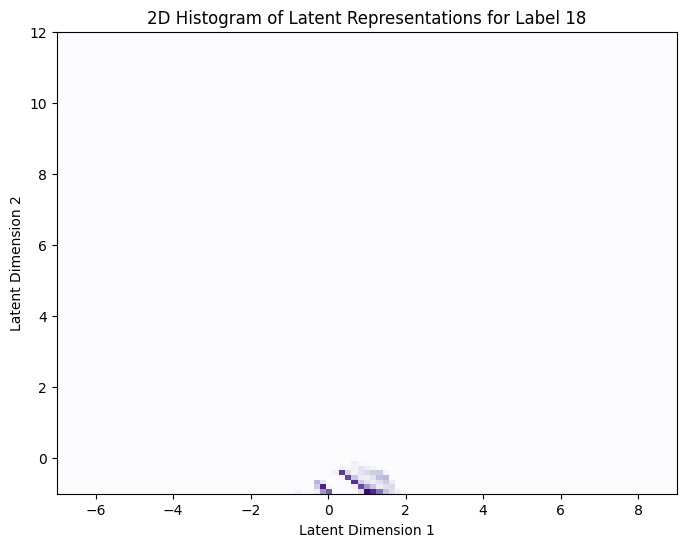

Plotting label 17 with 101 points.


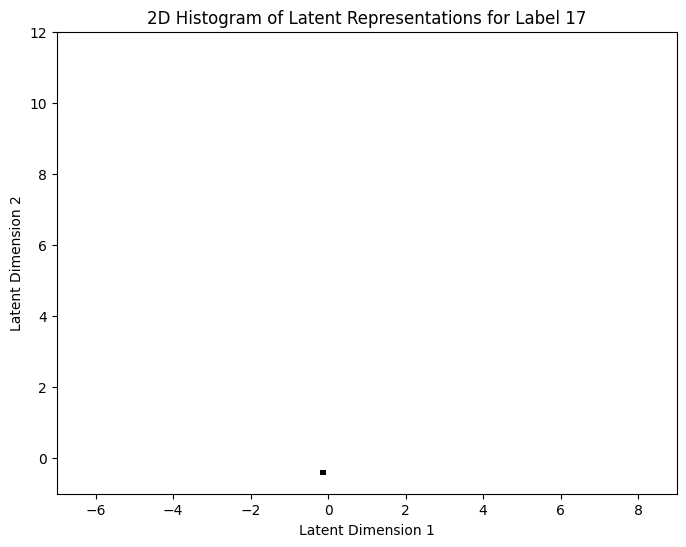

Plotting label 16 with 115 points.


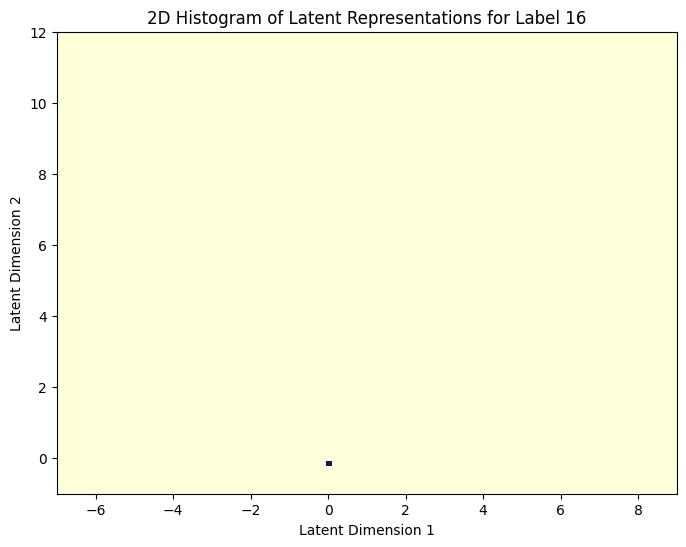

Plotting label 15 with 181 points.


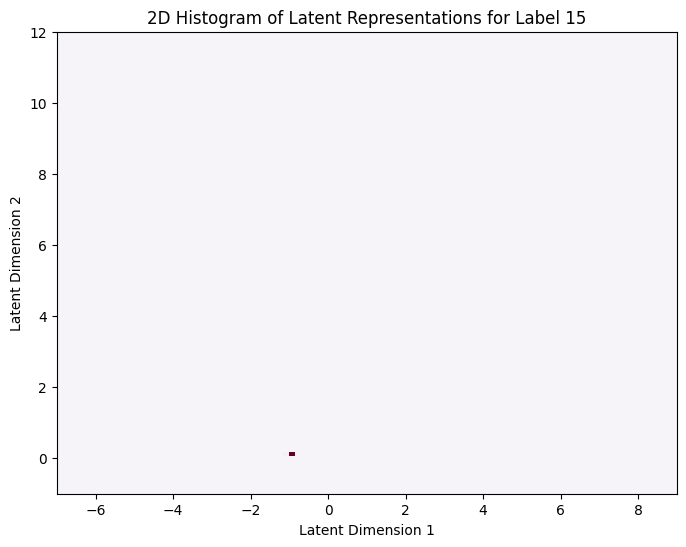

Plotting label 14 with 109 points.


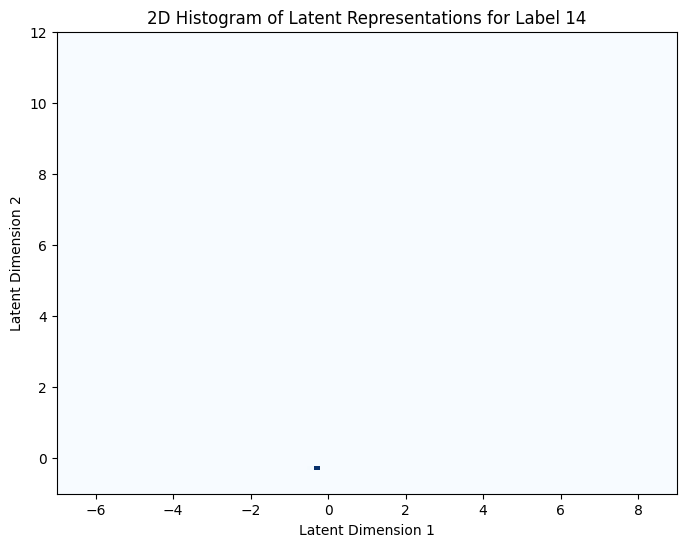

Plotting label 13 with 252 points.


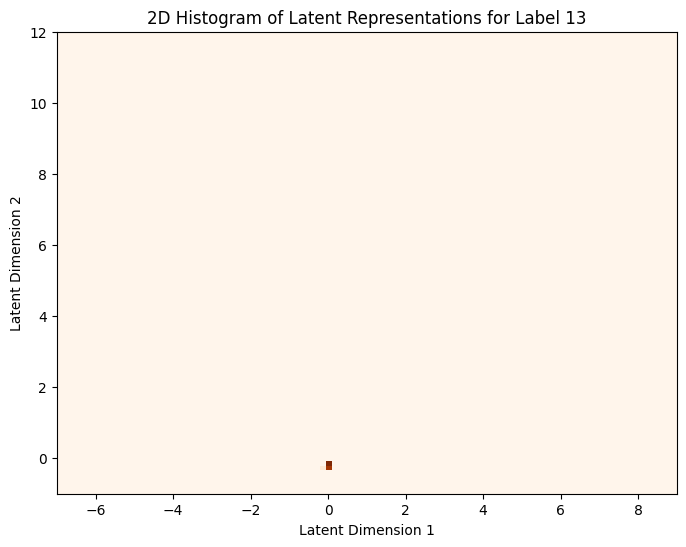

Plotting label 12 with 216 points.


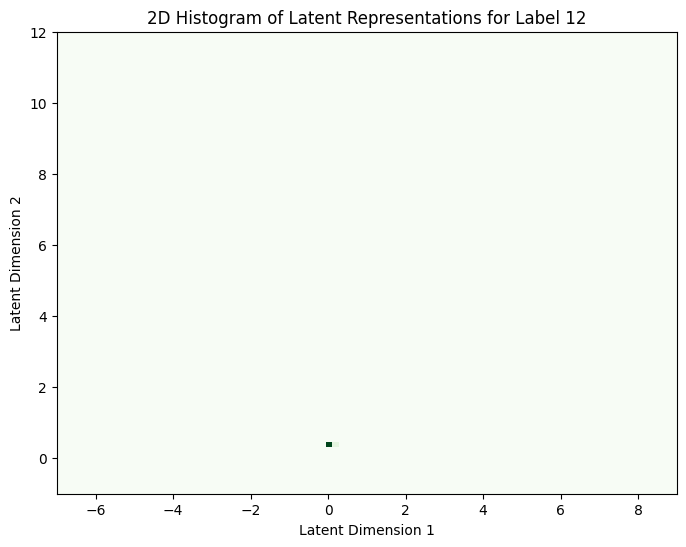

Plotting label 11 with 255 points.


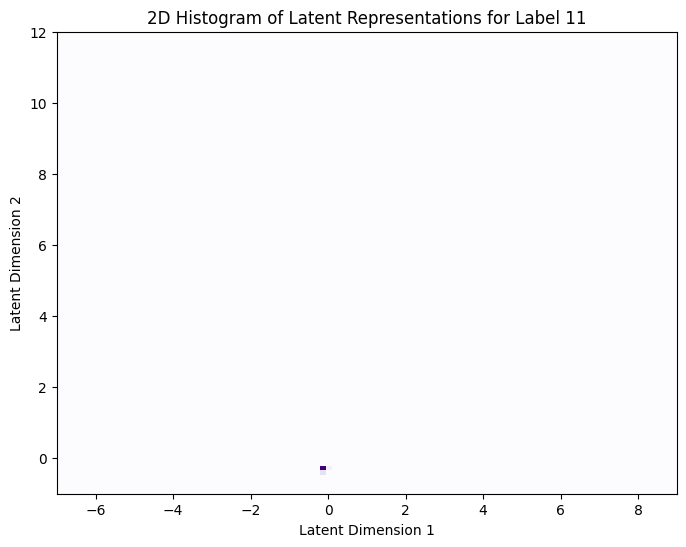

Plotting label 10 with 1094 points.


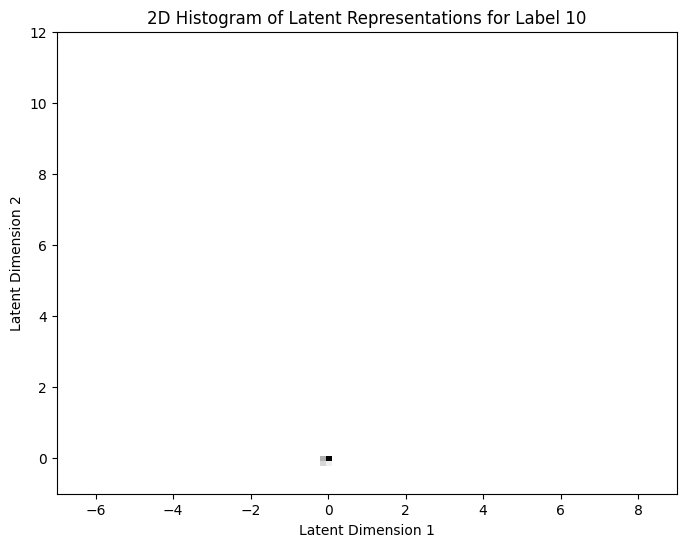

Plotting label 9 with 695 points.


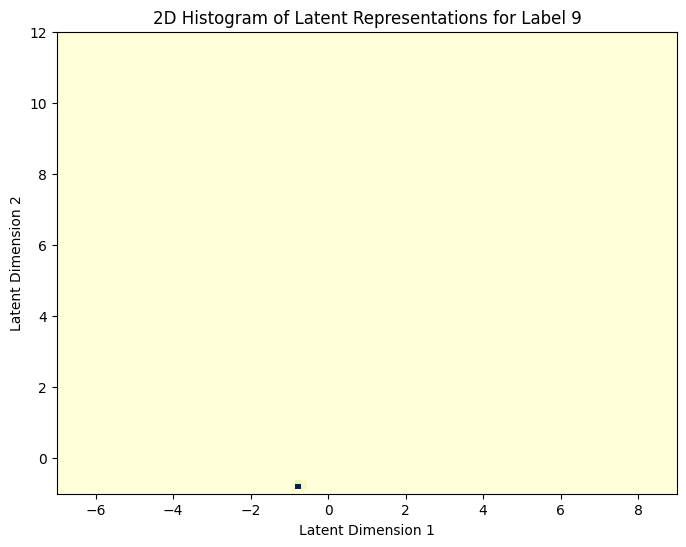

Plotting label 8 with 2981 points.


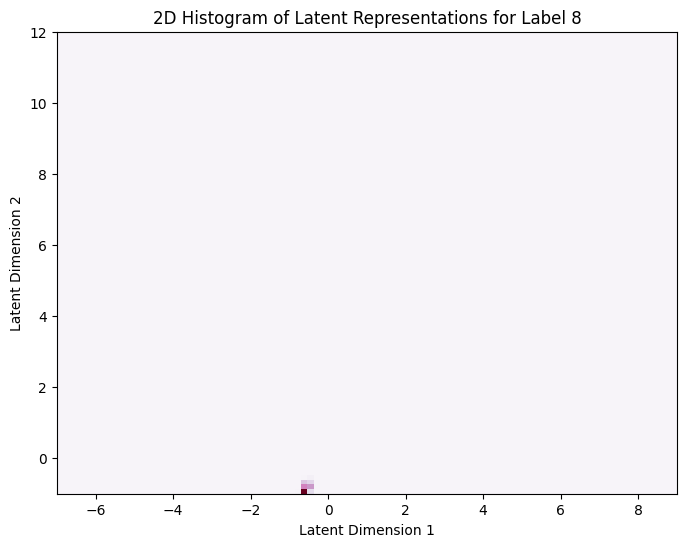

Plotting label 7 with 22896 points.


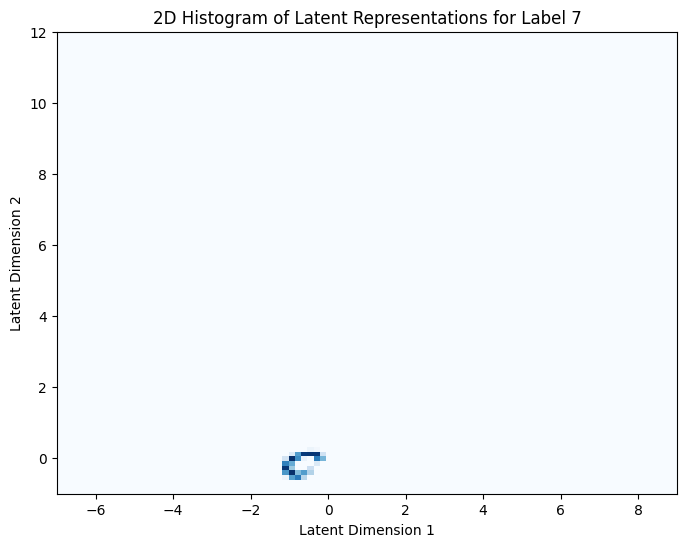

Plotting label 6 with 1267 points.


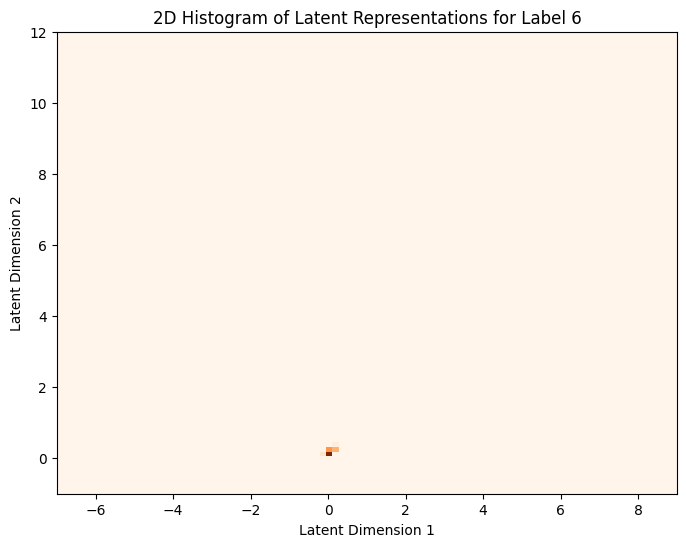

Plotting label 5 with 141487 points.


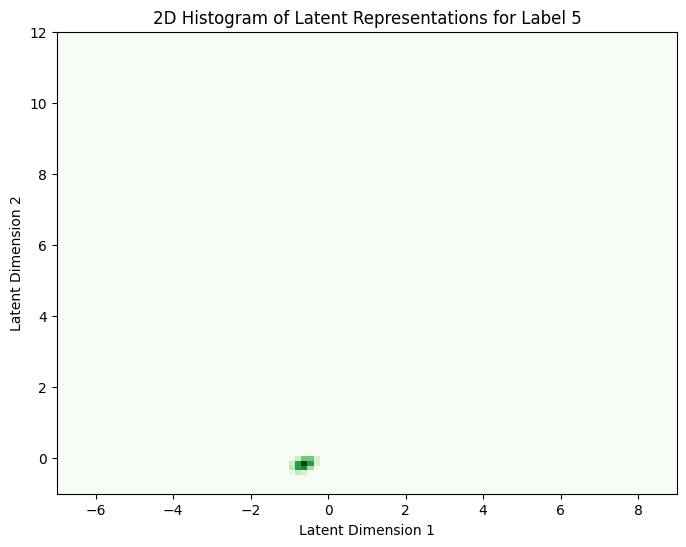

Plotting label 4 with 127833 points.


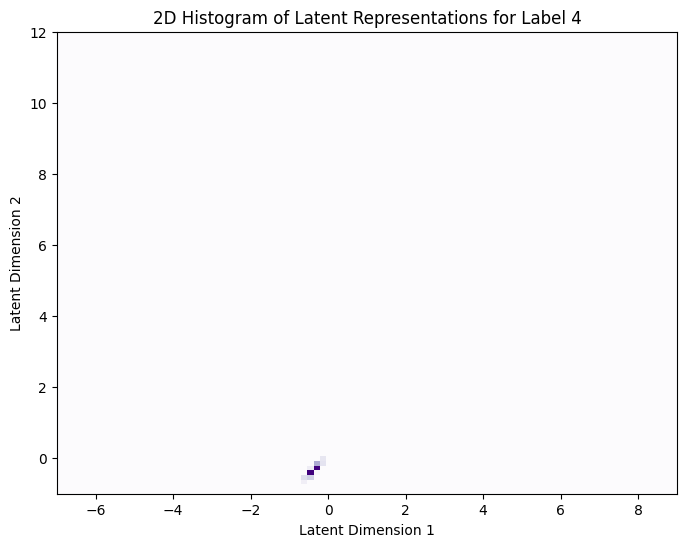

Plotting label 3 with 217106 points.


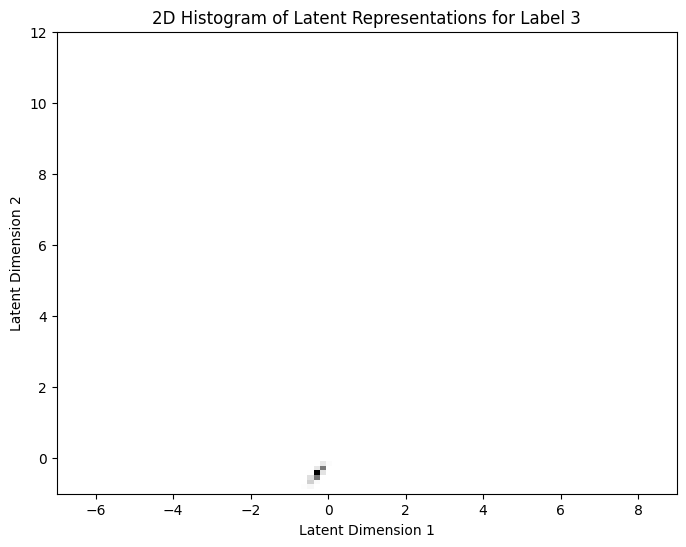

Plotting label 2 with 6193 points.


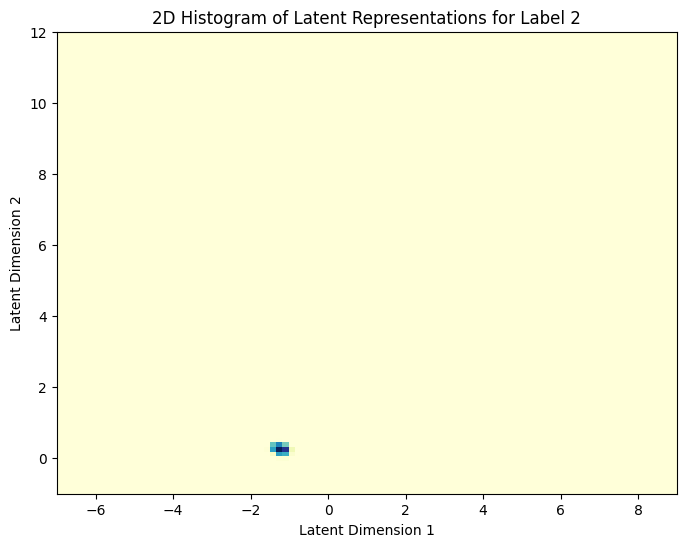

Plotting label 1 with 104051 points.


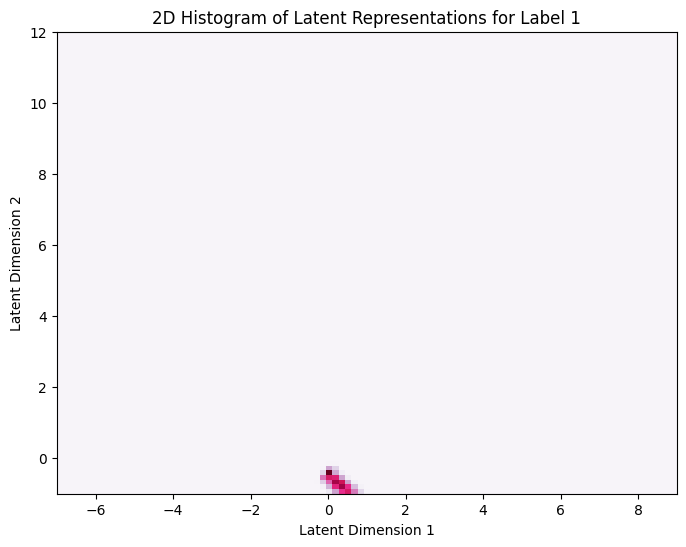

Plotting label 0 with 28614 points.


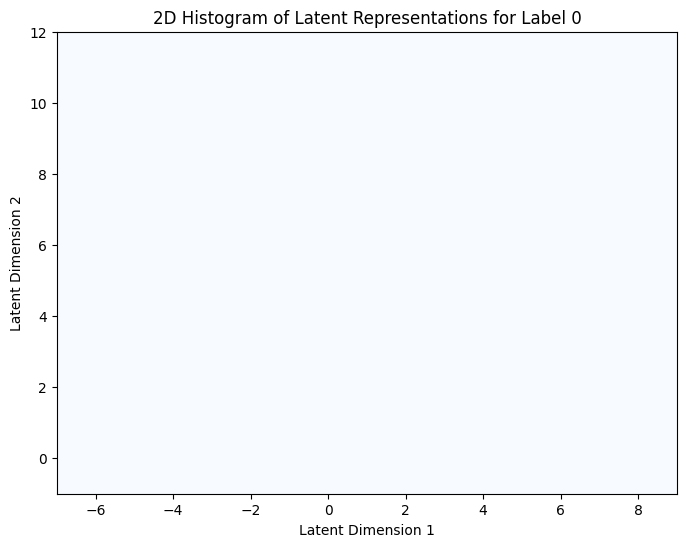

In [71]:
#逐个画出cluster的分布，保持颜色同上
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 
cluster_total=np.load("../data/clusters.npz")
labels=cluster_total['labels']
unique_labels = np.unique(labels)
colors_list=['Blues', 'Oranges', 'Greens', 'Purples', 'Greys', 'YlGnBu', 'PuRd']
color_flag=0
bins=(np.linspace(-7, 9, 100), np.linspace(-1, 12, 100))
for label in np.flip(unique_labels): 
    label_mask = (labels == label)
    print(f"Plotting label {label} with {np.sum(label_mask)} points.")
    plt.figure(figsize=(8, 6))
    plt.hist2d(z1[label_mask], z2[label_mask], bins=bins, cmap=colors_list[color_flag])
    color_flag = (color_flag + 1) % len(colors_list)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(f'2D Histogram of Latent Representations for Label {label}')
    plt.show()

# 回到能量

In [72]:
import torch
from sklearn.preprocessing import StandardScaler

ckpt = torch.load("../data/autoencoder_checkpoint.pt", map_location="cpu",weights_only=False)




In [73]:
import sys
from pathlib import Path

project_root = Path.cwd().parent # 按你的目录结构改
sys.path.insert(0, str(project_root))

from script.dim_reducing import AutoEncoder

model=AutoEncoder(input_dim=4, latent_dim=2)    
model.encoder.load_state_dict(ckpt["encoder_state"])
model.decoder.load_state_dict(ckpt["decoder_state"])
model.eval()

scaler = StandardScaler()
scaler.mean_ = ckpt["x_mean"]
scaler.scale_ = ckpt["x_std"]

model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [74]:
#从latent中还原数据
import torch
import numpy as np

model.eval()

with torch.no_grad():
    z_tensor = torch.as_tensor(latent, dtype=torch.float32)
    x_scaled_recon = model.decoder(z_tensor)

# 转成 numpy
x_scaled_recon = x_scaled_recon.cpu().numpy()

# 反归一化，回到原始数据空间
x_reconstructed = scaler.inverse_transform(x_scaled_recon)


In [75]:
ene_p_MeV=x_reconstructed[:,0]  #还原后的ene_p_MeV
ene_d_MeV=x_reconstructed[:,1]  #还原后的ene_d_MeV
log_time_dff_us=x_reconstructed[:,2]  #还原后的log_time_dff_us
log_vertex_distance_mm=x_reconstructed[:,3]  #还原后的log_vertex_distance_mm

In [76]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

labels = hdb_data['labels']
unique_labels = np.unique(labels)

colors_list = ['Blues', 'Oranges', 'Greens', 'Purples', 'Greys', 'YlGnBu', 'PuRd']

fig, ax = plt.subplots(figsize=(8, 6))
bins=(np.linspace(0, 12, 1000), np.linspace(6, 12, 1000))
color_flag = 0
for label in unique_labels:
    if label == -1:
        continue

    label_mask = (labels == label)
    if np.sum(label_mask) < number_of_points*0.001:
        continue
    print(f"Plotting label {label} with {np.sum(label_mask)} points.")
    ax.hist2d(
        ene_p_MeV[label_mask],
        ene_d_MeV[label_mask],
        bins=bins,
        cmap=colors_list[color_flag],
        norm=LogNorm(),
        alpha=0.5    # 关键：半透明叠加
    )

    color_flag = (color_flag + 1) % len(colors_list)

ax.set_xlabel('Reconstructed Prompt Energy (MeV)')
ax.set_ylabel('Reconstructed Delayed Energy (MeV)')
ax.set_title('Overlaid 2D Histograms of Clusters in Latent Space')

plt.show()


KeyError: 'labels is not a file in the archive'

Adding label 15 with 145978 points.
Adding label 14 with 284 points.
Adding label 13 with 315 points.
Adding label 12 with 118852 points.
Adding label 11 with 679 points.
Adding label 10 with 3704 points.
Adding label 9 with 605 points.
Adding label 8 with 486 points.
Adding label 7 with 168406 points.
Adding label 6 with 199817 points.
Adding label 5 with 911 points.
Adding label 4 with 389 points.
Adding label 3 with 526 points.
Adding label 2 with 347 points.
Adding label 1 with 86178 points.
Adding label 0 with 218 points.


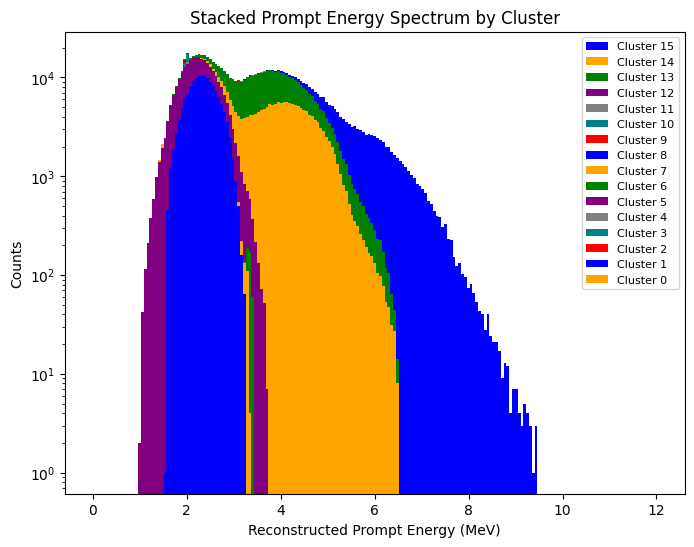

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = hdb_data['labels']
unique_labels = np.unique(labels)

colors_list = ['Blue', 'Orange', 'Green', 'Purple', 'Grey', 'Teal', 'Red']

# 所有 cluster 的能量数组
prompt_energy_clusters = []
cluster_colors = []
cluster_labels = []

bins_prompt = np.linspace(0, 12, 200)

color_flag = 0

for label in np.flip(unique_labels):
    if label == -1:
        continue

    mask = labels == label
    if np.sum(mask) < number_of_points * 0.001:
        continue

    print(f"Adding label {label} with {np.sum(mask)} points.")

    prompt_energy_clusters.append(ene_p_MeV[mask])
    cluster_colors.append(colors_list[color_flag])
    cluster_labels.append(f"Cluster {label}")

    color_flag = (color_flag + 1) % len(colors_list)

plt.figure(figsize=(8, 6))
plt.hist(
    prompt_energy_clusters,
    bins=bins_prompt,
    stacked=True,
    color=cluster_colors,
    label=cluster_labels
)
plt.yscale('log')

plt.xlabel("Reconstructed Prompt Energy (MeV)")
plt.ylabel("Counts")
plt.title("Stacked Prompt Energy Spectrum by Cluster")
plt.legend(fontsize=8)
plt.show()


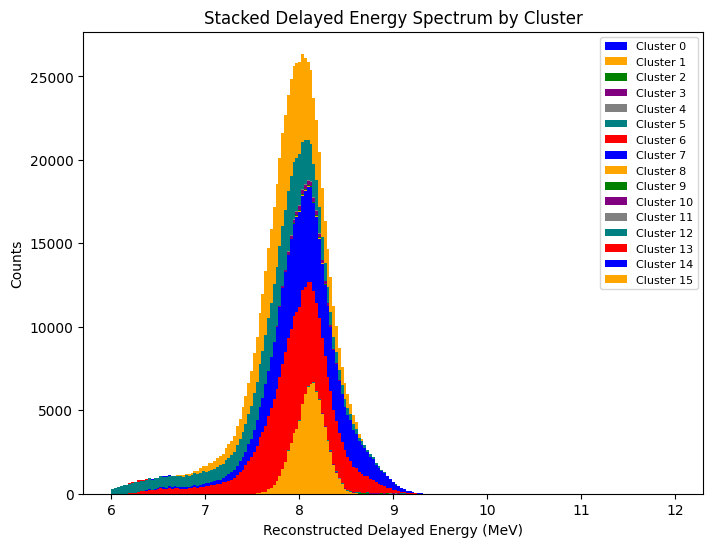

In [ ]:
delayed_energy_clusters = []
cluster_colors = []
cluster_labels = []

bins_delayed = np.linspace(6, 12, 200)

color_flag = 0
for label in unique_labels:
    if label == -1:
        continue

    mask = labels == label
    if np.sum(mask) < number_of_points * 0.001:
        continue

    delayed_energy_clusters.append(ene_d_MeV[mask])
    cluster_colors.append(colors_list[color_flag])
    cluster_labels.append(f"Cluster {label}")

    color_flag = (color_flag + 1) % len(colors_list)

plt.figure(figsize=(8, 6))
plt.hist(
    delayed_energy_clusters,
    bins=bins_delayed,
    stacked=True,
    color=cluster_colors,
    label=cluster_labels
)

plt.xlabel("Reconstructed Delayed Energy (MeV)")
plt.ylabel("Counts")
plt.title("Stacked Delayed Energy Spectrum by Cluster")
plt.legend(fontsize=8)
plt.show()
